# AI-Driven Workforce Analytics: Employee Attrition Prediction with Workload Insights

## Final Year Project - Data Analytics Pipeline

**Project Overview:**  
This project explores workload as a measurable factor enriching traditional attrition prediction models. By linking workload-related attributes (hours worked, travel frequency, role tenure) with conventional HR predictors (salary, performance, satisfaction), we build a nuanced framework highlighting both attrition risk and workload imbalance.

**Pipeline Phases:**
1. Data Ingestion & Understanding
2. Data Cleaning & Preprocessing
3. Exploratory Data Analysis (EDA)
4. Handling Data Imbalance
5. Feature Engineering & Selection
6. Data Transformation
7. Data Partition

**Output:** Analysis-ready dataset for downstream machine learning modeling.

<h2>Setup Configuration</h2>

In [1]:
# Always install into the active kernel's environment
!{sys.executable} -m pip install pandas numpy matplotlib seaborn shap joblib imbalanced-learn boto3 s3fs

# Import required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import joblib
#import imbalanced_learn
import inspect
import os
import sys
import boto3
from io import StringIO, BytesIO
from IPython.display import display, HTML
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import ( roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss)
#from sklearn.cluster import KMeans

# Import custom modules
from modules import (
    data_cleaning, data_explore, data_ingestion, data_partition, data_transformation, 
    eda, feature_engineering, imbalance_handling, init, post_transformation_eda
)

# Configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max.columns', None)
pd.set_option('display.width', 1000)
np.random.seed(42)

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('data', exist_ok=True)

print("Environment configured successfully")
print("Output directories created: 'outputs/', 'data/'")

# Auto-reload modules on change
%load_ext autoreload
%autoreload 2

/bin/sh: {sys.executable}: command not found
Environment configured successfully
Output directories created: 'outputs/', 'data/'


In [2]:
from modules.data_ingestion import inspect_data

s3 = boto3.client('s3')

bucket_name = 'fypemployeeattrition'
file_key = 'Extended_Employee_Performance_and_Productivity_Data_realistic_highpattern.csv'

# Get the object
obj = s3.get_object(Bucket=bucket_name, Key=file_key)

# Read into pandas DataFrame
data = obj['Body'].read().decode('utf-8')
df_raw = pd.read_csv(StringIO(data))

df_raw.info()
info_df = inspect_data(df_raw)

2025-11-19 03:02:54,051 | INFO | Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Employee_ID                  100000 non-null  int64  
 1   Department                   100000 non-null  object 
 2   Gender                       100000 non-null  object 
 3   Age                          100000 non-null  int64  
 4   Job_Title                    100000 non-null  object 
 5   Hire_Date                    100000 non-null  object 
 6   Years_At_Company             100000 non-null  int64  
 7   Education_Level              100000 non-null  object 
 8   Performance_Score            100000 non-null  float64
 9   Monthly_Salary               100000 non-null  float64
 10  Work_Hours_Per_Week          100000 non-null  float64
 11  Projects_Handled             100000 non-null  int64  
 12  Overtime_Hours               100000 non-null  float64
 13  

Column,Type,Non-Null,Null,Null%,Unique
Employee_ID,int64,100000,0,0.00,100000
Department,object,100000,0,0.00,9
Gender,object,100000,0,0.00,3
Age,int64,100000,0,0.00,43
Job_Title,object,100000,0,0.00,7
Hire_Date,object,100000,0,0.00,3463
Years_At_Company,int64,100000,0,0.00,11
Education_Level,object,100000,0,0.00,4
Performance_Score,float64,100000,0,0.00,400
Monthly_Salary,float64,100000,0,0.00,90936


Resigned,Count,Percentage
False,89990,89.99
True,10010,10.01


Feature,count,mean,std,min,25%,50%,75%,max
Employee_ID,100000.0,50000.50,28867.66,1.0,25000.75,50000.50,75000.25,100000.00
Age,100000.0,41.12,11.12,20.0,31.00,41.00,51.00,62.00
Years_At_Company,100000.0,4.48,2.87,0.0,2.00,4.00,7.00,10.00
Performance_Score,100000.0,3.64,0.64,1.0,3.23,3.66,4.08,5.00
Monthly_Salary,100000.0,6654.73,3316.94,300.0,5235.43,6097.10,7259.12,98202.96
Work_Hours_Per_Week,100000.0,36.89,4.18,20.0,34.10,36.80,39.70,55.50
Projects_Handled,100000.0,3.20,1.84,0.0,2.00,3.00,4.00,14.00
Overtime_Hours,100000.0,1.57,5.85,0.0,0.30,0.70,1.50,156.40
Sick_Days,100000.0,3.05,1.75,0.0,2.00,3.00,4.00,13.00
Team_Size,100000.0,7.00,2.45,1.0,5.00,7.00,9.00,19.00


Count,count
Marketing,11216
Finance,11200
Operations,11181
IT,11131
Sales,11122
Legal,11118
Customer Support,11116
HR,10960
Engineering,10956


Count,count
Male,48031
Female,48001
Other,3968


Count,count
Specialist,14507
Manager,14325
Technician,14285
Analyst,14261
Engineer,14217
Consultant,14210
Developer,14195


Count,count
2025-10-29,5108
2024-04-07,46
2023-08-16,46
2024-06-15,46
2023-06-27,45
2016-09-20,45
2019-06-06,45
2018-12-22,44
2022-07-10,44
2017-01-01,43


Count,count
Bachelor,50041
High School,30004
Master,14904
PhD,5051


Count,count
Sometimes,39918
Often,19989
Rarely,18001
Never,12075
Always,10017


Count,count
False,89990
True,10010


In [4]:
pd.set_option('display.max_columns', None)
df_raw.head(10)

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2023-10-07,2,High School,3.69,4523.03,39.8,4,144.0,1,Sometimes,8,28.2,1,7.04,False
1,2,Finance,Male,29,Developer,2025-05-24,0,High School,3.38,7290.79,37.9,2,0.6,3,Always,4,NaN,0,7.99,False
2,3,Finance,Male,55,Specialist,2017-07-30,8,High School,3.76,8114.38,36.9,2,0.3,3,Sometimes,7,17.4,2,8.17,False
3,4,Customer Support,Female,48,Analyst,2018-12-12,7,Bachelor,4.41,5952.56,37.0,2,1.1,5,Often,4,24.4,2,5.51,False
4,5,Engineering,Female,36,Analyst,2022-11-14,3,Bachelor,4.17,5093.78,46.3,5,3.8,2,Rarely,3,17.5,1,9.78,False
5,6,IT,Male,43,Manager,2017-06-13,8,High School,5.00,9092.83,39.8,1,0.1,2,Often,6,10.8,3,6.09,False
6,7,IT,Male,37,Technician,2025-04-02,1,Bachelor,4.70,4950.98,25.9,2,0.7,0,Often,9,15.2,0,9.68,False
7,8,Engineering,Female,55,Engineer,2016-10-31,9,Bachelor,2.90,5307.64,41.1,5,1.2,1,Rarely,8,26.5,3,6.83,False
8,9,Marketing,Female,55,Technician,2024-10-26,1,High School,3.35,4819.08,41.8,1,1.1,3,Sometimes,10,13.9,0,5.96,False
9,10,Engineering,Female,45,Consultant,2018-06-13,7,Bachelor,3.32,5923.40,44.3,2,4.0,2,Rarely,9,21.2,2,7.48,False


<h2>2.0 Initial Data Exploration</h2>

 Running EDA (mode='all')



==============================  SUMMARY FUNCTIONS  ==============================


→ basic_info
----------------------------------------------------------------------
Basic Data Information
Shape: (50, 20)

Data Types:
Employee_ID                      int64
Department                      object
Gender                          object
Age                              int64
Job_Title                       object
Hire_Date                       object
Years_At_Company                 int64
Education_Level                 object
Performance_Score              float64
Monthly_Salary                 float64
Work_Hours_Per_Week            float64
Projects_Handled                 int64
Overtime_Hours                 float64
Sick_Days                        int64
Remote_Work_Frequency           object
Team_Size                        int64
Training_Hours                 float64
Promotions                       int64
Employee_Satisfaction_Score    float64
Resigned  

,Missing Count,Percent
Training_Hours,5,10.0





→ numerical_summary
----------------------------------------------------------------------


,Employee_ID,Age,Years_At_Company,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,45.000000,50.000000,50.000000
mean,25.50000,41.980000,4.280000,3.743400,6524.248200,37.020000,3.380000,4.014000,2.540000,7.240000,18.417778,1.320000,7.303000
std,14.57738,11.316396,3.110483,0.664062,2002.164295,4.585336,1.748352,20.226059,1.528104,2.653915,6.991108,1.077412,1.253928
min,1.00000,24.000000,0.000000,2.420000,4113.380000,22.800000,1.000000,0.000000,0.000000,3.000000,4.400000,0.000000,3.670000
25%,13.25000,29.500000,1.250000,3.325000,5030.990000,33.950000,2.000000,0.425000,1.250000,5.000000,13.900000,0.000000,6.337500
50%,25.50000,43.000000,3.500000,3.605000,5928.725000,37.250000,3.000000,1.000000,2.000000,7.000000,19.000000,1.000000,7.560000
75%,37.75000,52.000000,7.750000,4.385000,7484.427500,40.500000,4.750000,1.475000,4.000000,8.750000,24.400000,2.000000,8.192500
max,50.00000,60.000000,9.000000,5.000000,13856.510000,46.300000,7.000000,144.000000,6.000000,17.000000,30.000000,4.000000,9.780000






==============================  VISUALIZATION FUNCTIONS  ==============================


→ correlation_heatmap
----------------------------------------------------------------------


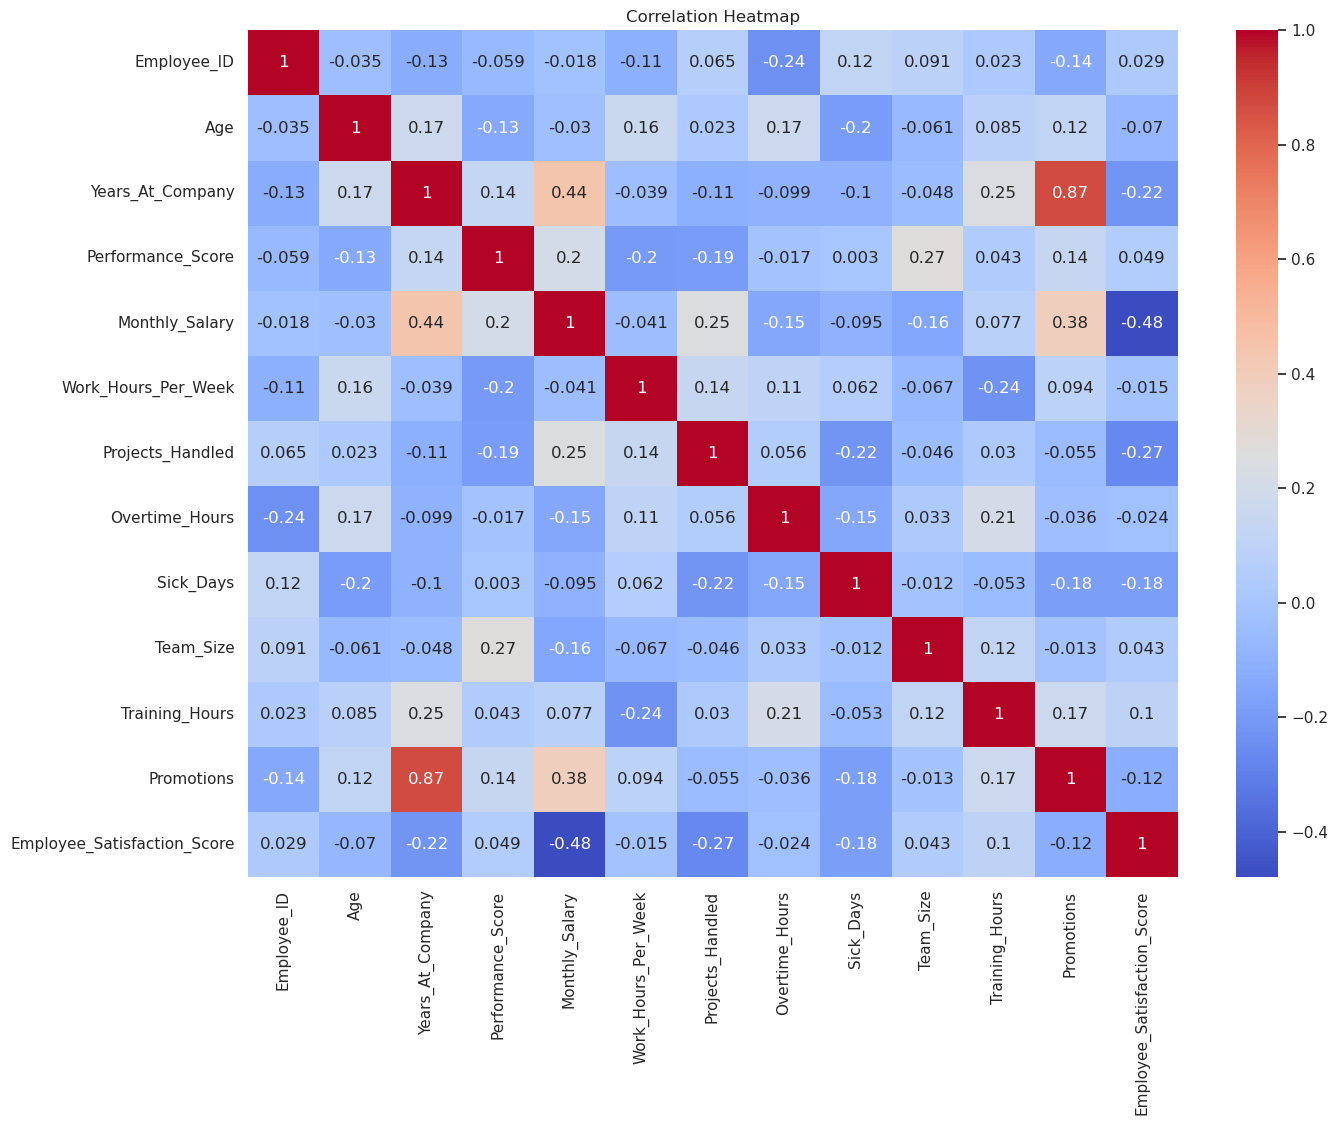




→ detect_outliers
----------------------------------------------------------------------
Employee_ID: 0 outliers
Age: 0 outliers
Years_At_Company: 0 outliers
Performance_Score: 0 outliers
Monthly_Salary: 1 outliers
Work_Hours_Per_Week: 1 outliers
Projects_Handled: 0 outliers
Overtime_Hours: 5 outliers
Sick_Days: 0 outliers
Team_Size: 1 outliers
Training_Hours: 0 outliers
Promotions: 0 outliers
Employee_Satisfaction_Score: 0 outliers


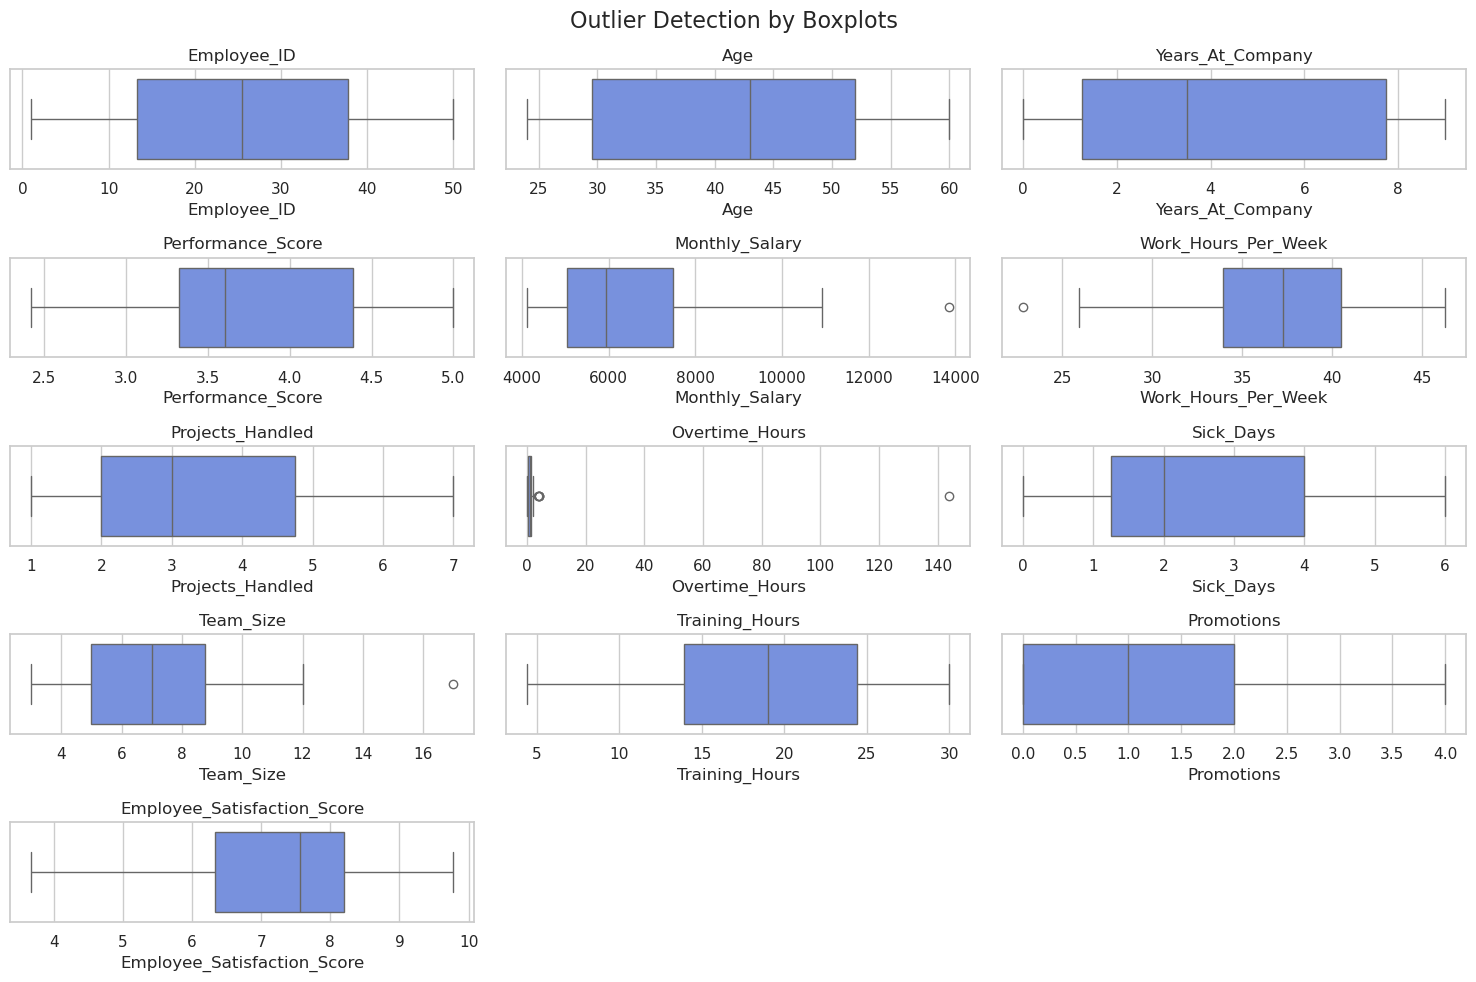




→ plot_categorical
----------------------------------------------------------------------


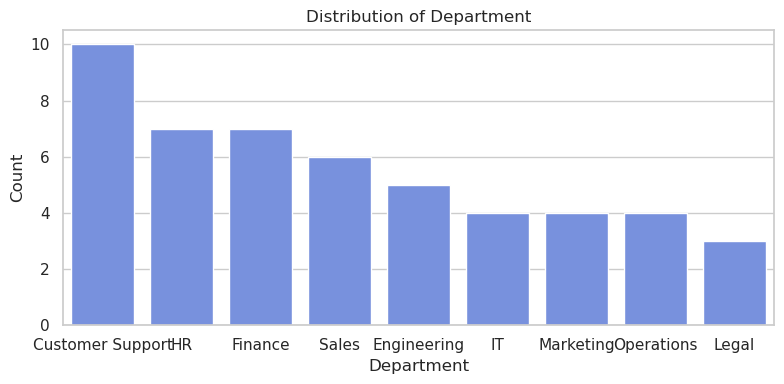

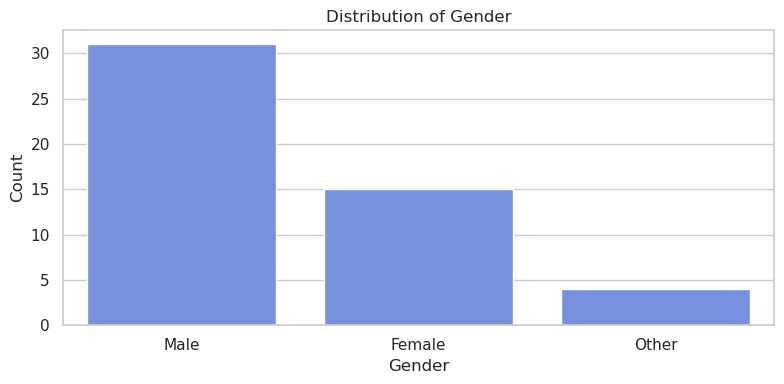

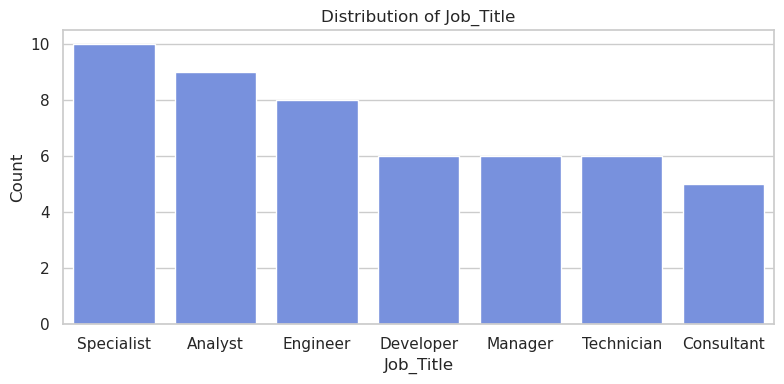

2025-11-19 02:48:47,089 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 02:48:47,099 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


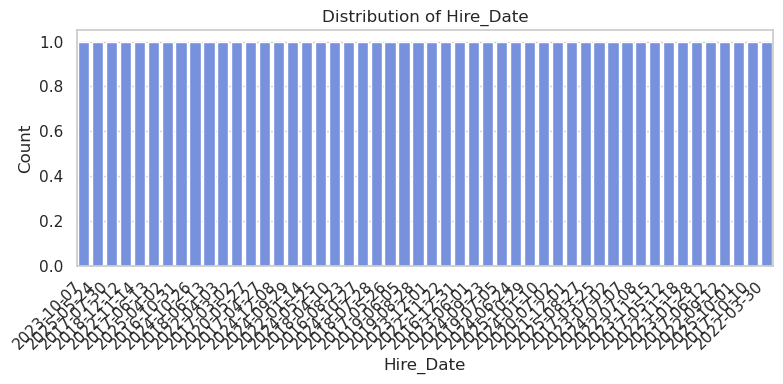

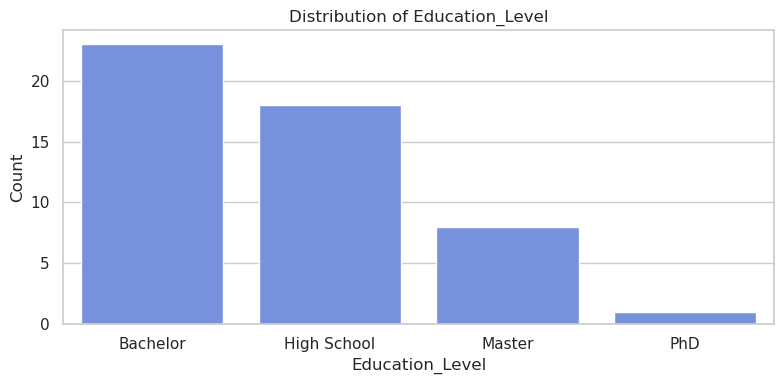

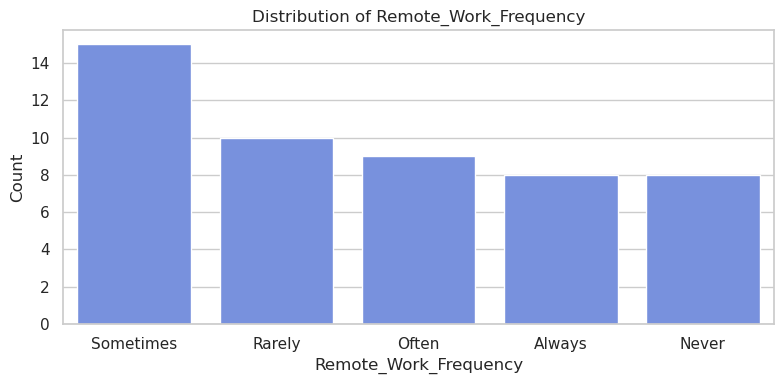

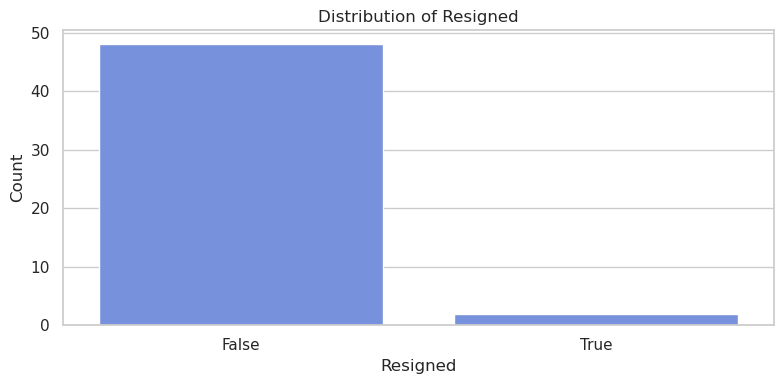




→ plot_numerical
----------------------------------------------------------------------


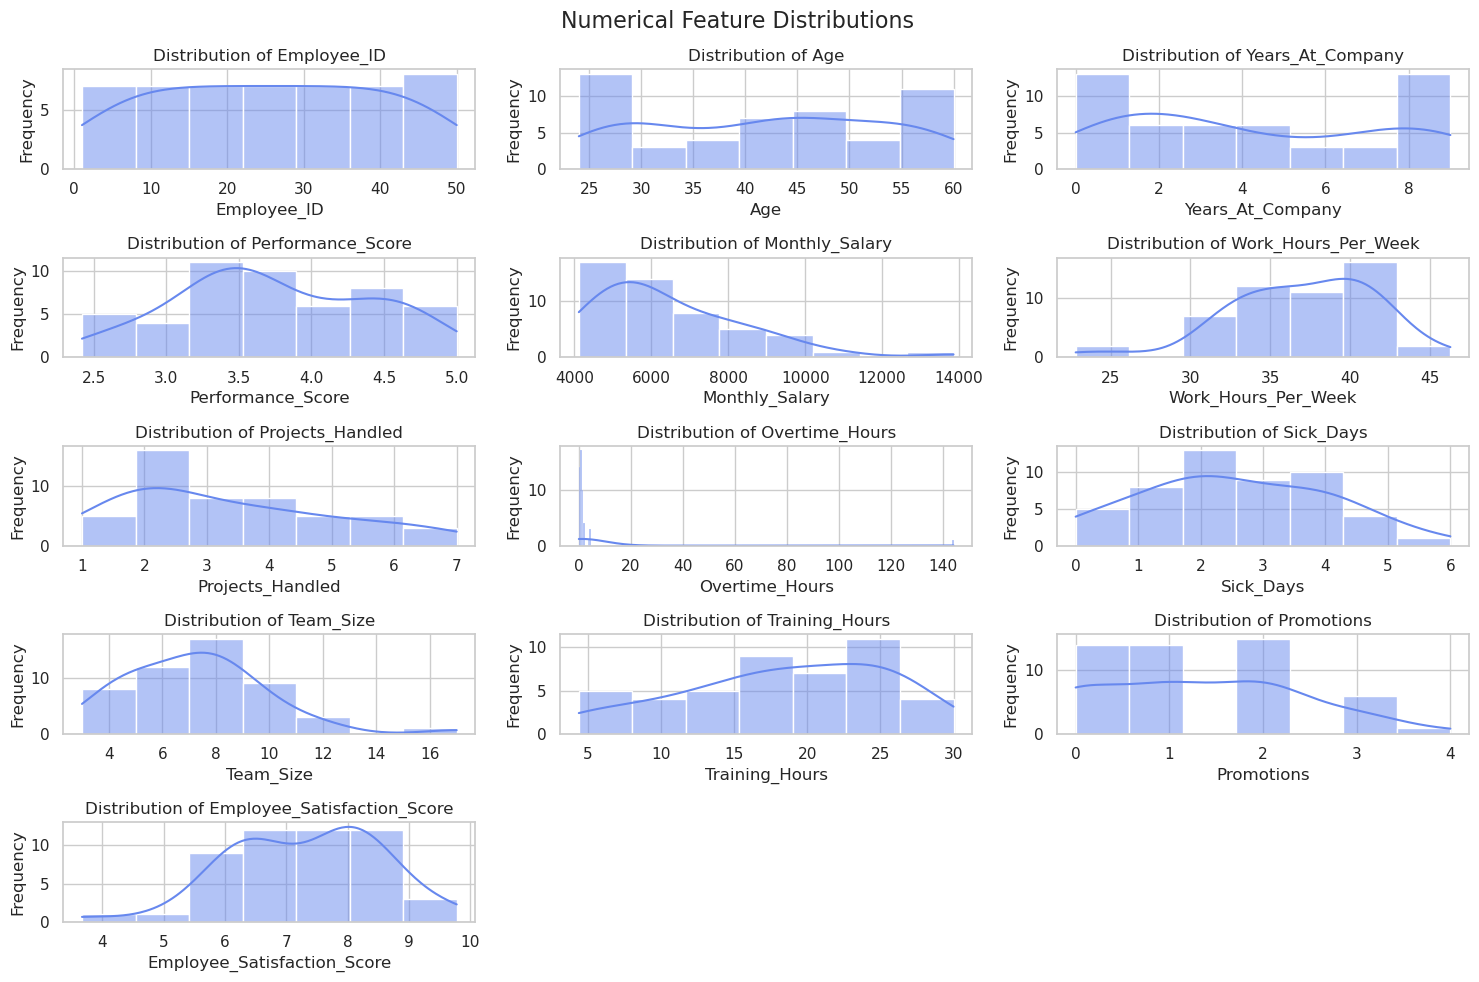




 EDA Completed!


In [5]:
from modules import data_explore

# Run summaries only (fast)
#data_explore.run_eda(df_raw, mode="summary")

# Run visualizations only
#data_explore.run_eda(df_raw, mode="visual")

# Or run full EDA
data_explore.run_eda(df_raw, mode="all")

<h2>3.0 Data Cleaning & Preprocessing</h2>

**Key Activities:**
- Handle missing values: Training_Hours (imputation strategy)
- Remove duplicate records
- Convert data types (dates, booleans, numerics)
- Detect outliers using IQR and Z-score methods

In [3]:
# clean data
df_clean, outlier_info = data_cleaning.clean_data(df_raw.copy())

# Save cleaned data into another csv file
df_clean.to_csv('data/cleaned_data.csv', index=False)
print("\n✓ Cleaned data saved to: data/cleaned_data.csv")

2025-11-19 03:03:05,536 | INFO | ================================================================================
2025-11-19 03:03:05,537 | INFO | STARTING DATA CLEANING PIPELINE
2025-11-19 03:03:05,537 | INFO | ================================================================================
2025-11-19 03:03:05,538 | INFO | ================================================================================
2025-11-19 03:03:05,538 | INFO | MISSING VALUE ANALYSIS
2025-11-19 03:03:05,539 | INFO | ================================================================================
2025-11-19 03:03:05,567 | INFO | 
Columns with missing values:
                Missing  Percentage
Training_Hours     4986        4.99
2025-11-19 03:03:05,571 | INFO | ✓ Training_Hours: Imputed 4986 missing values with median (19.2)
2025-11-19 03:03:05,572 | INFO | ================================================================================
2025-11-19 03:03:05,572 | INFO | DUPLICATE ANALYSIS
2025-11-19 03:03:05,573 


✓ Cleaned data saved to: data/cleaned_data.csv


In [4]:
df_clean

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2023-10-07,2,High School,3.69,4523.03,39.8,4,144.0,1,Sometimes,8,28.2,1,7.04,0
1,2,Finance,Male,29,Developer,2025-05-24,0,High School,3.38,7290.79,37.9,2,0.6,3,Always,4,19.2,0,7.99,0
2,3,Finance,Male,55,Specialist,2017-07-30,8,High School,3.76,8114.38,36.9,2,0.3,3,Sometimes,7,17.4,2,8.17,0
3,4,Customer Support,Female,48,Analyst,2018-12-12,7,Bachelor,4.41,5952.56,37.0,2,1.1,5,Often,4,24.4,2,5.51,0
4,5,Engineering,Female,36,Analyst,2022-11-14,3,Bachelor,4.17,5093.78,46.3,5,3.8,2,Rarely,3,17.5,1,9.78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,Finance,Male,27,Technician,2025-04-16,1,Bachelor,3.72,6232.82,41.7,2,1.2,2,Always,7,18.2,0,8.03,0
99996,99997,IT,Female,36,Consultant,2019-11-13,6,Master,2.91,6023.42,36.7,3,0.1,1,Sometimes,8,7.8,2,5.90,1
99997,99998,Operations,Male,53,Analyst,2017-08-23,8,High School,3.48,5875.00,26.1,1,3.2,2,Often,7,20.6,3,8.39,0
99998,99999,HR,Female,27,Consultant,2017-02-19,9,High School,3.20,5199.21,33.1,3,0.0,2,Never,12,21.6,3,5.59,0


## Phase 3: Exploratory Data Analysis (EDA)

**Objective:** Uncover patterns, distributions, and relationships between workload features and attrition.

**Key Activities:**
- Analyze target variable distribution (attrition rate)
- Explore workload features (hours, overtime, projects, sick days)
- Correlation analysis with attrition
- Categorical feature analysis (department, gender, education)
- Satisfaction and performance patterns
- Workload intensity deep dive

**Possible Enhancements:**
- auto-generated EDA summary report that aggregates key findings such as attrition rate, top correlated features, and chi-square results
- Upload the report into S3 bucket

2025-11-19 03:03:12,331 | INFO | ================================================================================
2025-11-19 03:03:12,332 | INFO | 🚀 STARTING EXPLORATORY DATA ANALYSIS (INITIAL PHASE)
2025-11-19 03:03:12,333 | INFO | ================================================================================
2025-11-19 03:03:12,333 | INFO | === TARGET VARIABLE ANALYSIS: ATTRITION ===


,Count,Percentage (%)
Resigned,,
0,89990.000000,89.990000
1,10010.000000,10.010000
Imbalance Ratio,8.99:1,


2025-11-19 03:03:12,433 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:12,511 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:12,871 | INFO | ✅ Saved Attrition Distribution Plots: outputs/01_attrition_distribution.png


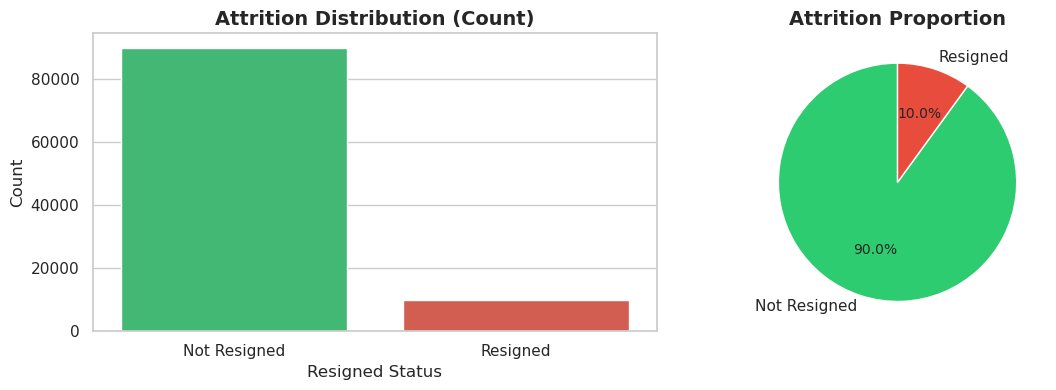

2025-11-19 03:03:12,985 | INFO | === WORKLOAD FEATURES ANALYSIS ===


2025-11-19 03:03:13,142 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:13,230 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:13,372 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:13,463 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:13,599 | INFO | Using categorical units to plot a list of strings that are all parsable as 

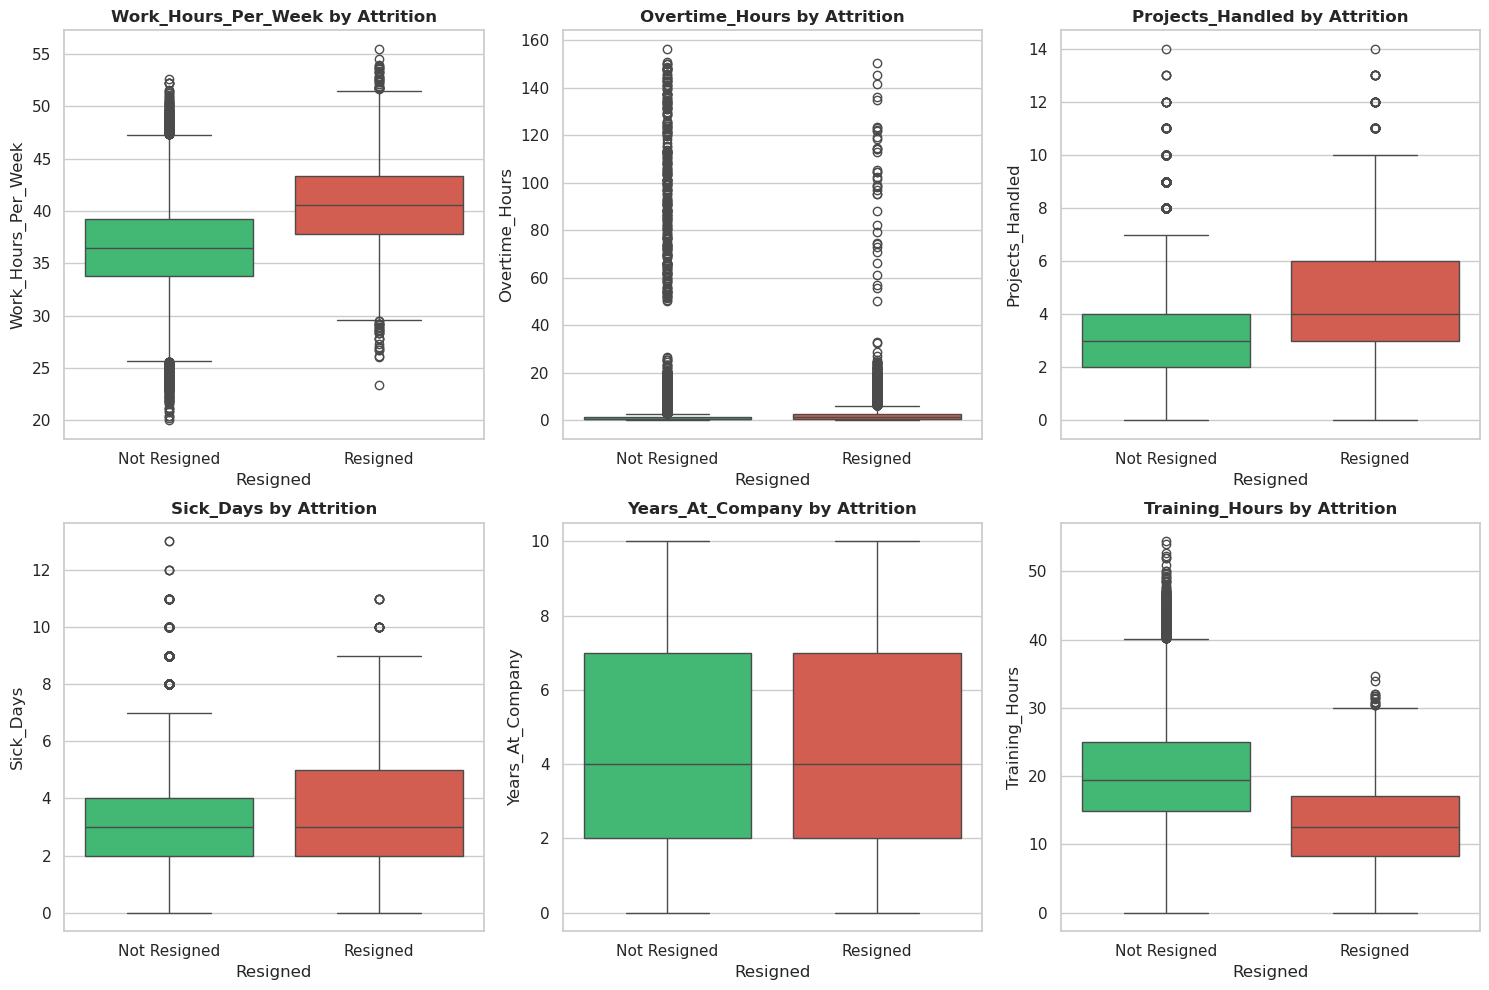

2025-11-19 03:03:16,053 | INFO | === CORRELATION ANALYSIS ===


,Age,Years_At_Company,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
Age,1.000000,0.010000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.010000,0.010000,-0.000000,0.000000
Years_At_Company,0.010000,1.000000,-0.010000,0.150000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.850000,0.000000,0.000000
Performance_Score,0.000000,-0.010000,1.000000,-0.000000,-0.080000,-0.050000,-0.020000,-0.020000,0.000000,0.080000,0.030000,0.170000,-0.280000
Monthly_Salary,0.000000,0.150000,-0.000000,1.000000,-0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.130000,-0.000000,0.000000
Work_Hours_Per_Week,-0.000000,0.000000,-0.080000,-0.000000,1.000000,0.060000,0.120000,0.020000,0.000000,-0.090000,-0.040000,-0.180000,0.290000
Projects_Handled,0.000000,0.000000,-0.050000,0.040000,0.060000,1.000000,0.010000,0.020000,0.000000,-0.060000,-0.030000,-0.130000,0.200000
Overtime_Hours,0.000000,0.000000,-0.020000,0.000000,0.120000,0.010000,1.000000,0.010000,0.000000,-0.020000,-0.000000,-0.030000,0.060000
Sick_Days,0.000000,-0.000000,-0.020000,0.000000,0.020000,0.020000,0.010000,1.000000,0.000000,-0.020000,-0.010000,-0.040000,0.070000
Team_Size,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000
Training_Hours,-0.010000,-0.000000,0.080000,0.000000,-0.090000,-0.060000,-0.020000,-0.020000,-0.000000,1.000000,0.040000,0.170000,-0.280000


2025-11-19 03:03:17,296 | INFO | ✅ Saved Full Correlation Matrix: outputs/03a_full_correlation_matrix.png


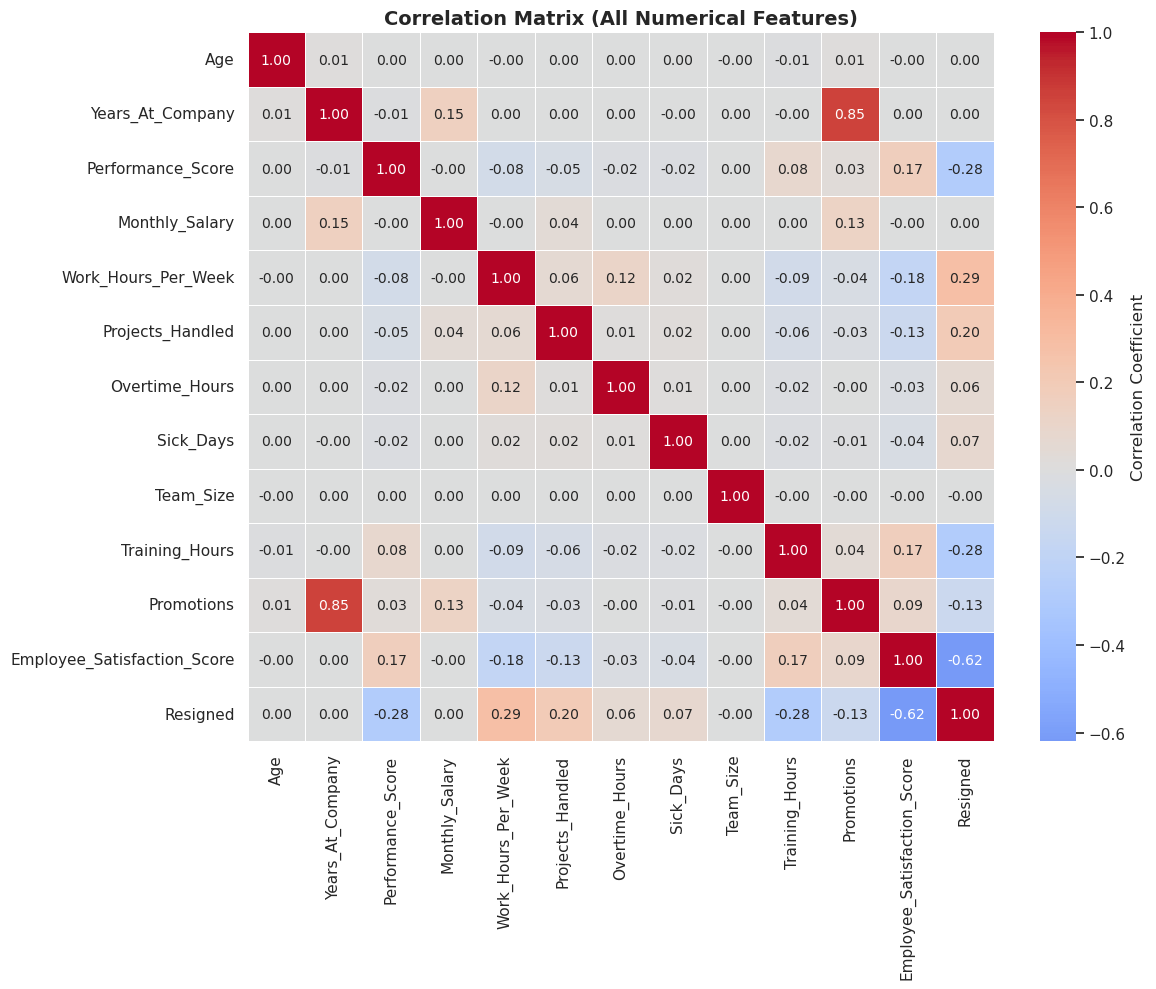

2025-11-19 03:03:18,028 | INFO | ✅ Saved Feature Correlation with Target: outputs/03b_feature_correlation_with_attrition.png


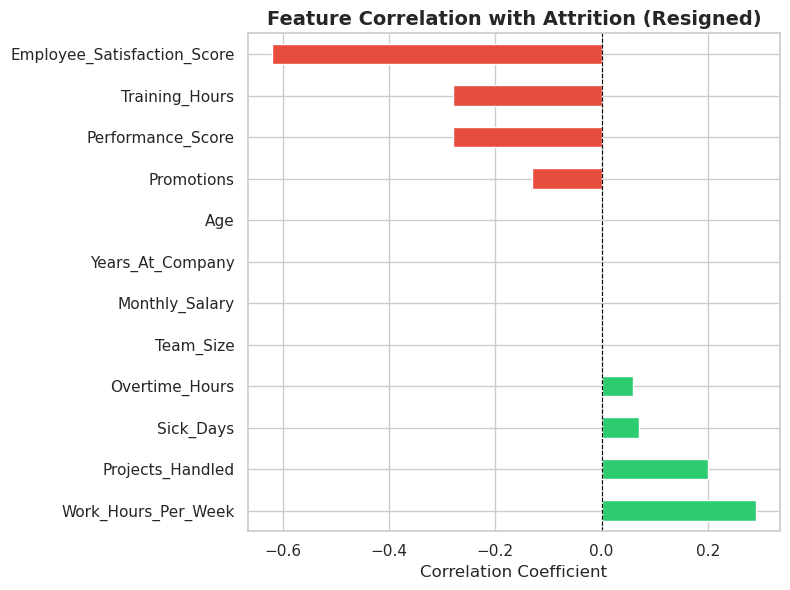

2025-11-19 03:03:18,169 | INFO | === CATEGORICAL FEATURES VS ATTRITION ===


,Feature,Chi2,P-Value,Significant
0,Department,9.179500,0.327400,No
1,Gender,0.319600,0.852300,No
2,Job_Title,2.716300,0.843500,No
3,Education_Level,0.554100,0.906800,No
4,Remote_Work_Frequency,0.803900,0.937900,No


2025-11-19 03:03:19,725 | INFO | ✅ Saved Categorical Attrition Rates: outputs/04_categorical_attrition_rates.png


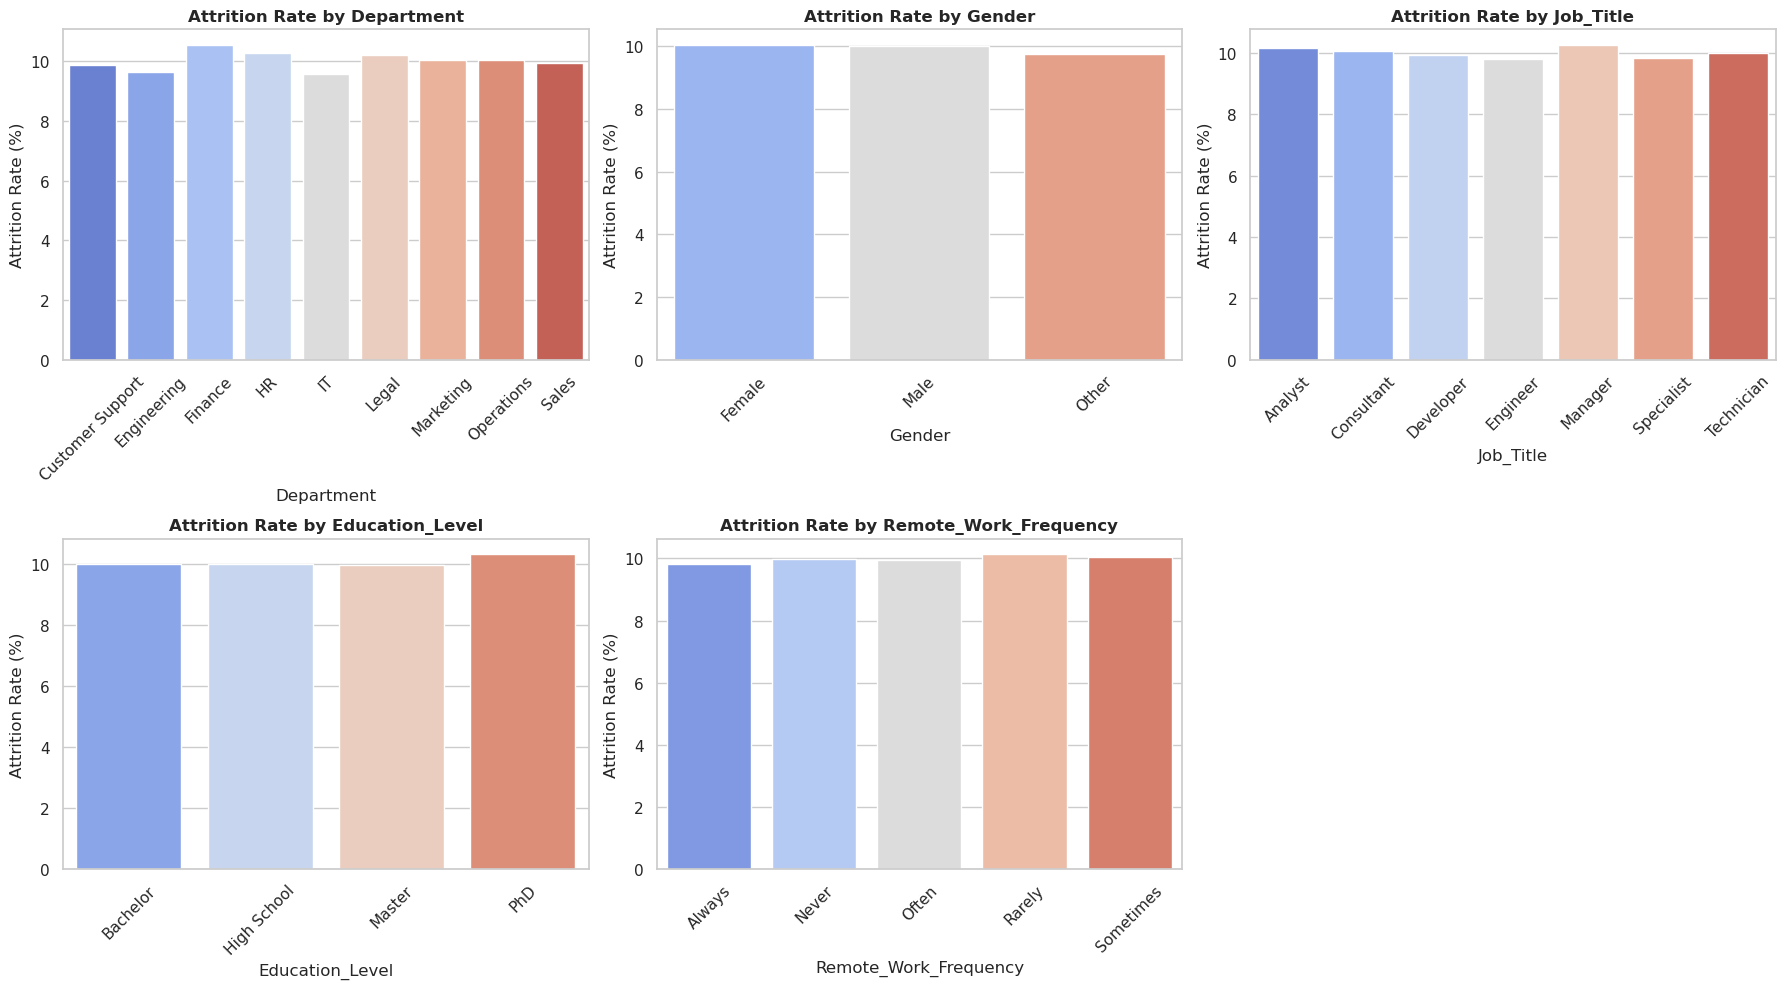

2025-11-19 03:03:20,247 | INFO | === SATISFACTION & PERFORMANCE ANALYSIS ===


,Employee_Satisfaction_Score,Performance_Score
Resigned,,
0,7.490000,3.700000
1,4.320000,3.100000


2025-11-19 03:03:20,334 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:20,418 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:20,788 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:20,871 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-19 03:03:21,617 | INFO | ✅ Saved Satisfaction & Performance: outputs/05_satisfaction_performance.png

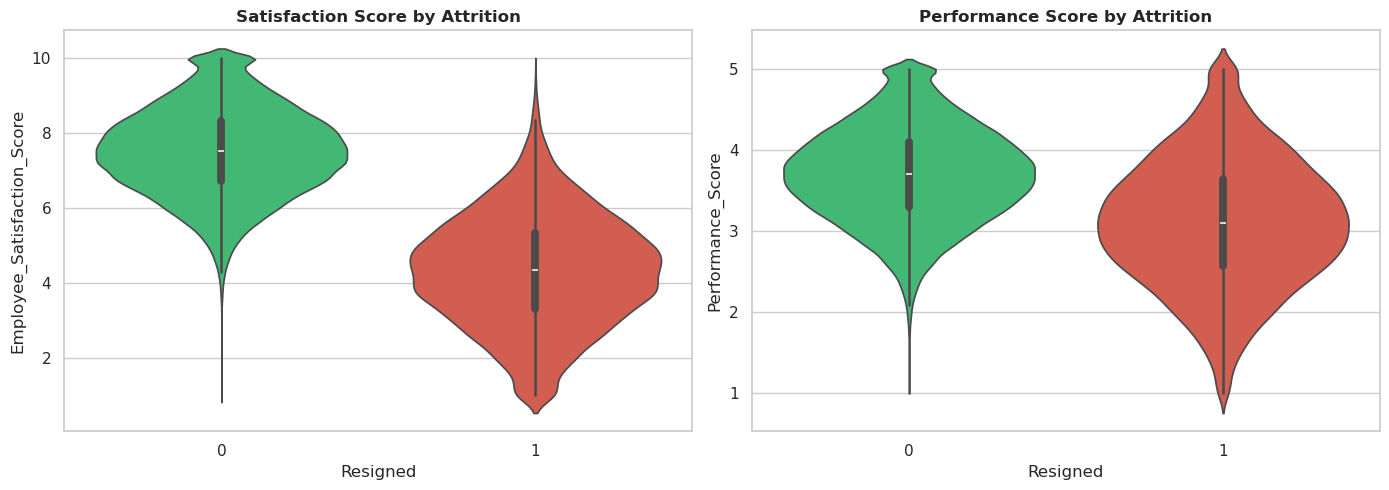

2025-11-19 03:03:21,785 | INFO | === WORKLOAD INTENSITY ANALYSIS ===


,sum,count,mean,Attrition_Rate_%
Workload_Category,,,,
Low (<35h),833,33228,0.030000,2.510000
Normal (35-40h),3657,44438,0.080000,8.230000
High (40-45h),4170,19615,0.210000,21.260000
Very High (>45h),1350,2719,0.500000,49.650000


2025-11-19 03:03:22,474 | INFO | ✅ Saved Workload Intensity Analysis: outputs/06_workload_intensity.png


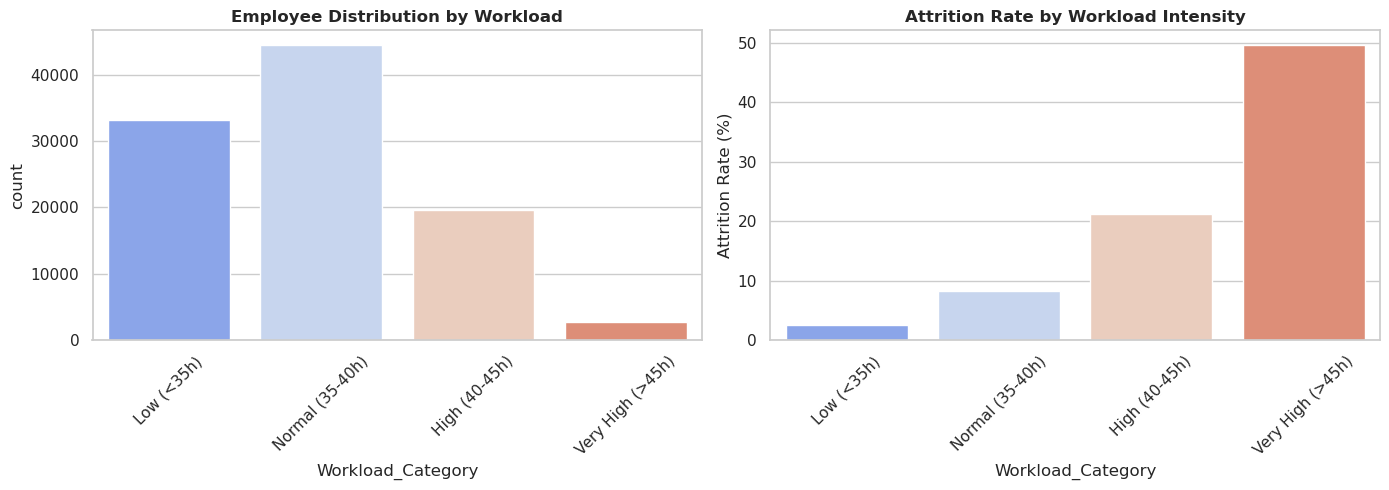

2025-11-19 03:03:22,656 | INFO | ================================================================================
2025-11-19 03:03:22,657 | INFO | ✅ INITIAL EDA COMPLETED SUCCESSFULLY
2025-11-19 03:03:22,658 | INFO | ================================================================================


In [5]:
# Perform EDA

eda_results = eda.perform_eda(df_clean.copy(), phase = "initial")

## Phase 5: Feature Engineering & Selection

**Objective:** Create workload-related features and identify the most influential predictors.

**Key Activities:**
- Engineer 12 new workload features:
  - Workload Intensity Score
  - Overwork/Underutilization Flags
  - Overtime Ratio
  - Project Load per Hour
  - Burnout Risk Score
  - Work-Life Balance Score
  - Tenure-Performance Ratio
  - Training Adequacy
  - Salary-Performance Gap
  - Age/Tenure Categories
- Encode categorical variables (one-hot encoding)
- Feature selection using:
  - Random Forest importance
  - Mutual Information
  - ANOVA F-statistic
  - Consensus ranking

**Rationale:**
- Workload features capture nuanced patterns (not just raw hours)
- Multiple selection methods ensure robust feature identification
- Consensus approach reduces method-specific bias

In [11]:
df_encoded

,Age,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned,Workload_Intensity,Is_Overworked,Is_Underutilized,Overtime_Ratio,Project_Load,Burnout_Risk,Work_Life_Balance,Tenure_Performance_Ratio,Training_Per_Year,Salary_Performance_Gap,Age_Group,Tenure_Category,Department_Customer Support,Department_Engineering,Department_Finance,Department_HR,Department_IT,Department_Legal,Department_Marketing,Department_Operations,Department_Sales,Gender_Female,Gender_Male,Gender_Other,Job_Title_Analyst,Job_Title_Consultant,Job_Title_Developer,Job_Title_Engineer,Job_Title_Manager,Job_Title_Specialist,Job_Title_Technician
0,55,2,1,3.69,4523.03,39.8,4,144.0,1,2,8,28.2,1,7.04,0,0.759929,0,0,0.904523,0.100503,0.3,2.800,0.527704,9.400000,-0.726040,4,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,29,0,1,3.38,7290.79,37.9,2,0.6,3,4,4,19.2,0,7.99,0,0.423008,0,0,0.003958,0.052770,0.0,9.970,0.000000,19.200000,0.593370,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,55,8,1,3.76,8114.38,36.9,2,0.3,3,2,7,17.4,2,8.17,0,0.412433,0,0,0.002033,0.054201,0.0,9.985,2.072539,1.933333,0.247177,4,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,48,7,2,4.41,5952.56,37.0,2,1.1,5,3,4,24.4,2,5.51,0,0.414967,0,0,0.007432,0.054054,0.2,9.945,1.552106,3.050000,-1.421466,3,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,36,3,2,4.17,5093.78,46.3,5,3.8,2,1,3,17.5,1,9.78,0,0.577432,1,0,0.020518,0.107991,0.6,6.660,0.702576,4.375000,-1.304905,2,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27,1,2,3.72,6232.82,41.7,2,1.2,2,4,7,18.2,0,8.03,0,0.462159,0,0,0.007194,0.047962,0.0,9.090,0.261780,9.100000,-0.257502,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
99996,36,6,3,2.91,6023.42,36.7,3,0.1,1,2,8,7.8,2,5.90,1,0.431478,0,0,0.000681,0.081744,0.0,9.995,1.993355,1.114286,0.946571,2,3,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
99997,53,8,1,3.48,5875.00,26.1,1,3.2,2,3,7,20.6,3,8.39,0,0.288567,0,1,0.030651,0.038314,0.3,9.840,2.234637,2.288889,0.010089,4,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
99998,27,9,1,3.20,5199.21,33.1,3,0.0,2,0,12,21.6,3,5.59,0,0.395286,0,1,0.000000,0.090634,0.0,10.000,2.727273,2.160000,0.244396,1,3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0



FEATURE ENGINEERING & SELECTION PIPELINE STARTED

FEATURE ENGINEERING: Workload-Based Features
✓ Created 12 new engineered features. Dataset shape: (100000, 32)

ENCODING CATEGORICAL FEATURES
✓ Ordinal encoded: Education_Level
✓ Ordinal encoded: Remote_Work_Frequency
✓ One-hot encoded nominal features: Department, Gender, Job_Title
✓ Encoding complete. Total features: 45

FEATURE SELECTION: Random Forest Importance


Feature,Importance
Employee_Satisfaction_Score,0.377950
Burnout_Risk,0.089367
Performance_Score,0.061909
Training_Hours,0.058804
Workload_Intensity,0.049024
Salary_Performance_Gap,0.034103
Work_Hours_Per_Week,0.030894
Training_Per_Year,0.027440
Work_Life_Balance,0.024281
Tenure_Performance_Ratio,0.024009


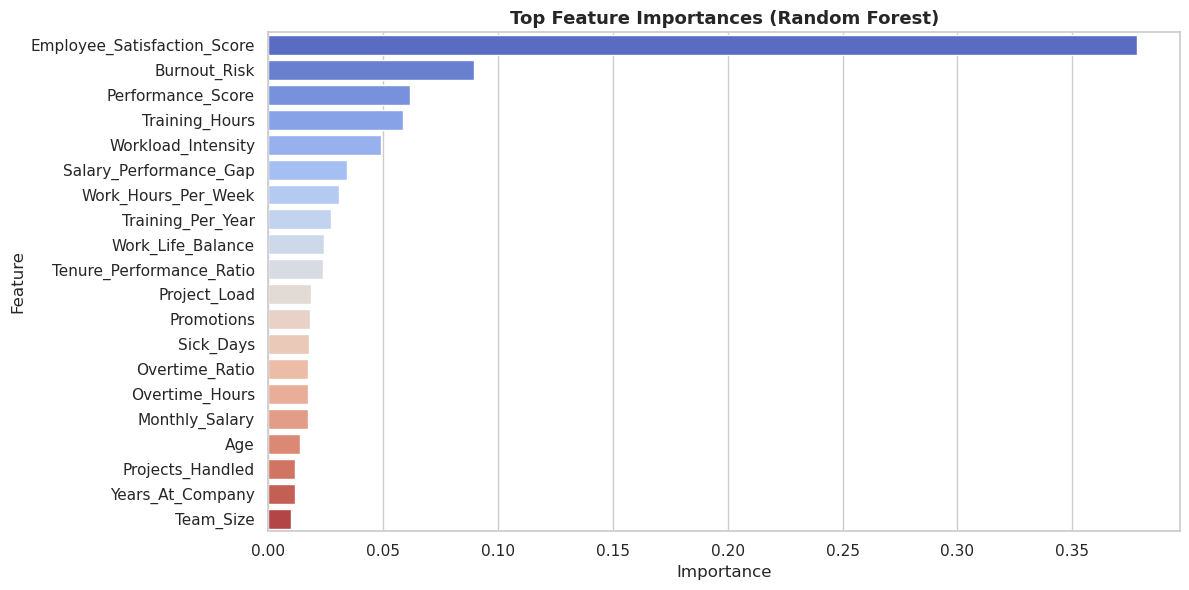


FEATURE SELECTION: Mutual Information


Feature,MI_Score
Employee_Satisfaction_Score,0.189188
Burnout_Risk,0.093471
Workload_Intensity,0.055860
Work_Hours_Per_Week,0.045756
Training_Hours,0.045211
Project_Load,0.044883
Performance_Score,0.044323
Overtime_Ratio,0.037134
Work_Life_Balance,0.034739
Training_Per_Year,0.029905


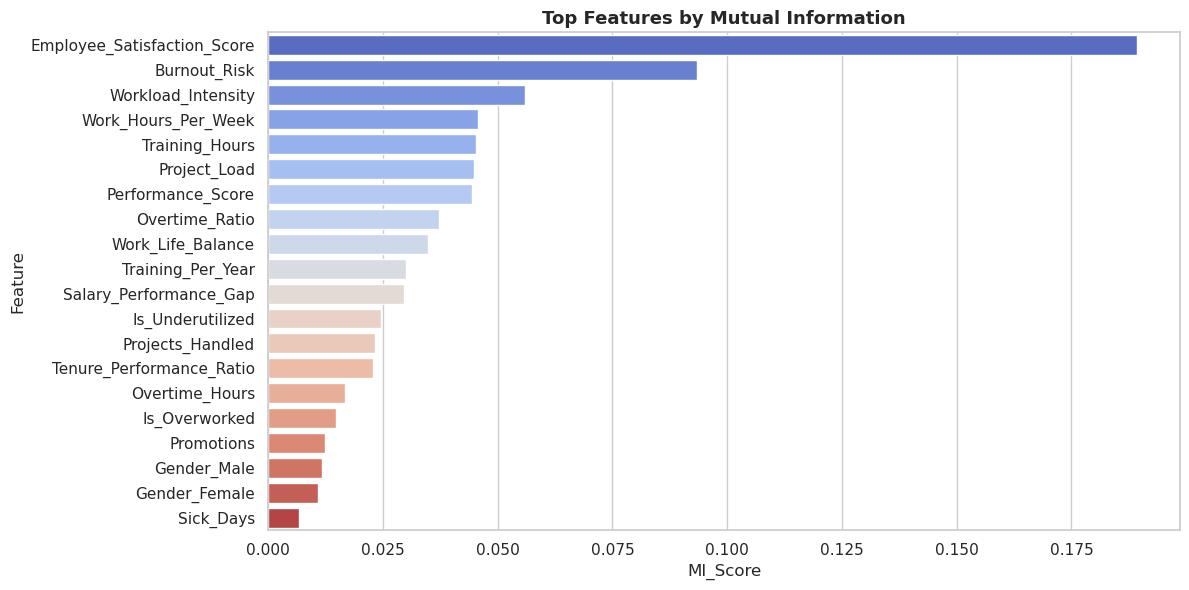


FEATURE SELECTION: ANOVA F-Statistic


Feature,F_Score,P_Value
Employee_Satisfaction_Score,61728.250098,0.000000e+00
Burnout_Risk,20402.982016,0.000000e+00
Workload_Intensity,13187.546840,0.000000e+00
Work_Life_Balance,9511.955674,0.000000e+00
Work_Hours_Per_Week,9446.742855,0.000000e+00
Training_Hours,8654.388044,0.000000e+00
Performance_Score,8524.090580,0.000000e+00
Is_Overworked,5125.462962,0.000000e+00
Projects_Handled,4253.019024,0.000000e+00
Salary_Performance_Gap,4168.846418,0.000000e+00



CONSENSUS FEATURE SELECTION

Top 20 Consensus Features:
                    Feature  RF_Rank  MI_Rank  F_Rank  Avg_Rank
Employee_Satisfaction_Score        1        1       1  1.000000
               Burnout_Risk        2        2       2  2.000000
         Workload_Intensity        5        3       3  3.666667
             Training_Hours        4        5       6  5.000000
        Work_Hours_Per_Week        7        4       5  5.333333
          Performance_Score        3        7       7  5.666667
          Work_Life_Balance        9        9       4  7.333333
     Salary_Performance_Gap        6       11      10  9.000000
               Project_Load       11        6      13 10.000000
          Training_Per_Year        8       10      14 10.666667
   Tenure_Performance_Ratio       10       14      15 13.000000
             Overtime_Ratio       14        8      18 13.333333
           Projects_Handled       18       13       9 13.333333
                 Promotions       12       17  

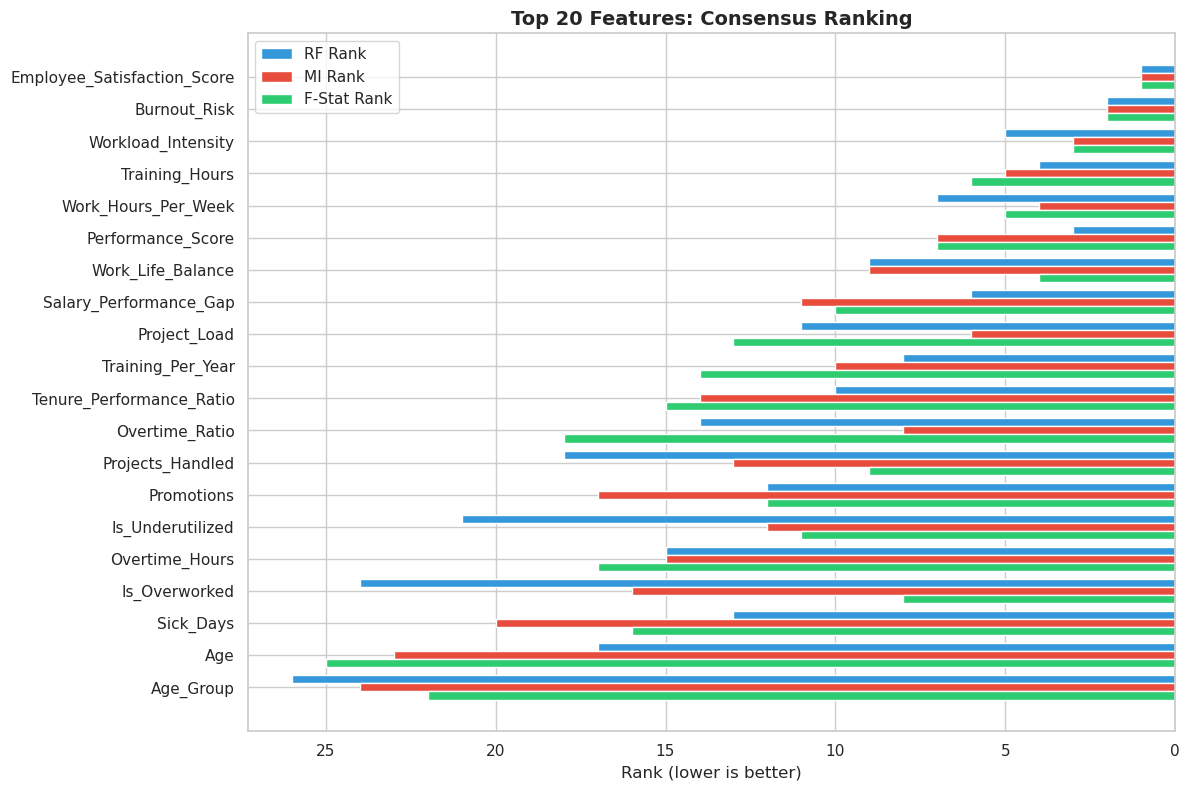


✓ FEATURE ENGINEERING & SELECTION COMPLETED SUCCESSFULLY

✓ Engineered data saved to: data/engineered_data.csv
✓ Encoded data saved to: data/encoded_data.csv


In [6]:
# Feature engineering & selection
df_engineered, df_encoded, feature_selection_results = feature_engineering.engineer_and_select_features(
    df_clean.copy(), 
    target_col='Resigned', 
    top_k=20
)

# Save engineered data
df_engineered.to_csv('data/engineered_data.csv', index=False)
df_encoded.to_csv('data/encoded_data.csv', index=False)
print("\n✓ Engineered data saved to: data/engineered_data.csv")
print("✓ Encoded data saved to: data/encoded_data.csv")

---
## Phase 4 (Continued): Apply Imbalance Handling

**Now that features are engineered, we apply SMOTE to the encoded dataset.**

2025-11-19 03:04:28,913 | INFO | Starting imbalance handling pipeline...
2025-11-19 03:04:28,914 | INFO | Analyzing class distribution...


,Class,Count,Percentage (%)
0,0,89990,89.99
1,1,10010,10.01


2025-11-19 03:04:28,920 | INFO | Imbalance ratio: 8.99:1
2025-11-19 03:04:28,921 | WARNING | Severe imbalance detected (ratio > 3:1)
2025-11-19 03:04:28,931 | INFO | Applying SMOTE...
2025-11-19 03:04:29,750 | INFO | SMOTE completed. Before: Counter({0: 89990, 1: 10010}) | After: Counter({0: 89990, 1: 89990})
2025-11-19 03:04:29,753 | INFO | Resampled dataset shape: (179980, 46)


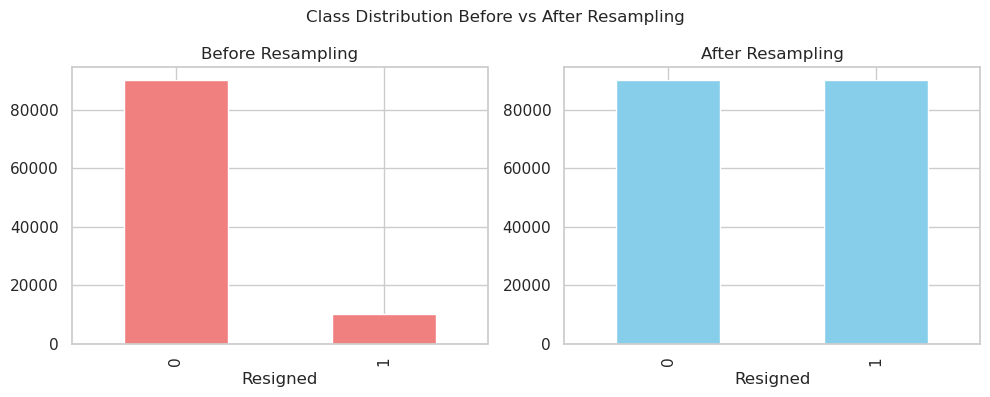


✓ Balanced data saved to: data/balanced_data.csv


In [7]:
# Prepare feature columns (all except target)
feature_cols = [col for col in df_encoded.columns if col != 'Resigned']

# Apply SMOTE
df_balanced, X_balanced, y_balanced = imbalance_handling.handle_imbalance(
    df_encoded.copy(),
    feature_cols=feature_cols,
    target_col='Resigned',
    method='smote',
    random_state=42
)

# Save balanced data
df_balanced.to_csv('data/balanced_data.csv', index=False)
print("\n✓ Balanced data saved to: data/balanced_data.csv")

---
## Phase 6: Data Transformation

**Objective:** Scale and normalize features for optimal model performance.

**Key Activities:**
- Compare scaling methods (Standard, MinMax, Robust)
- Apply StandardScaler (most common for ML)
- Visualize before/after distributions
- Analyze post-transformation correlations

**Rationale:**
- StandardScaler: Mean=0, Std=1 (required for many ML algorithms)
- Ensures features on comparable scales
- Improves convergence for gradient-based algorithms
- Maintains relative relationships between features


DATA TRANSFORMATION PIPELINE

COMPARING SCALING METHODS


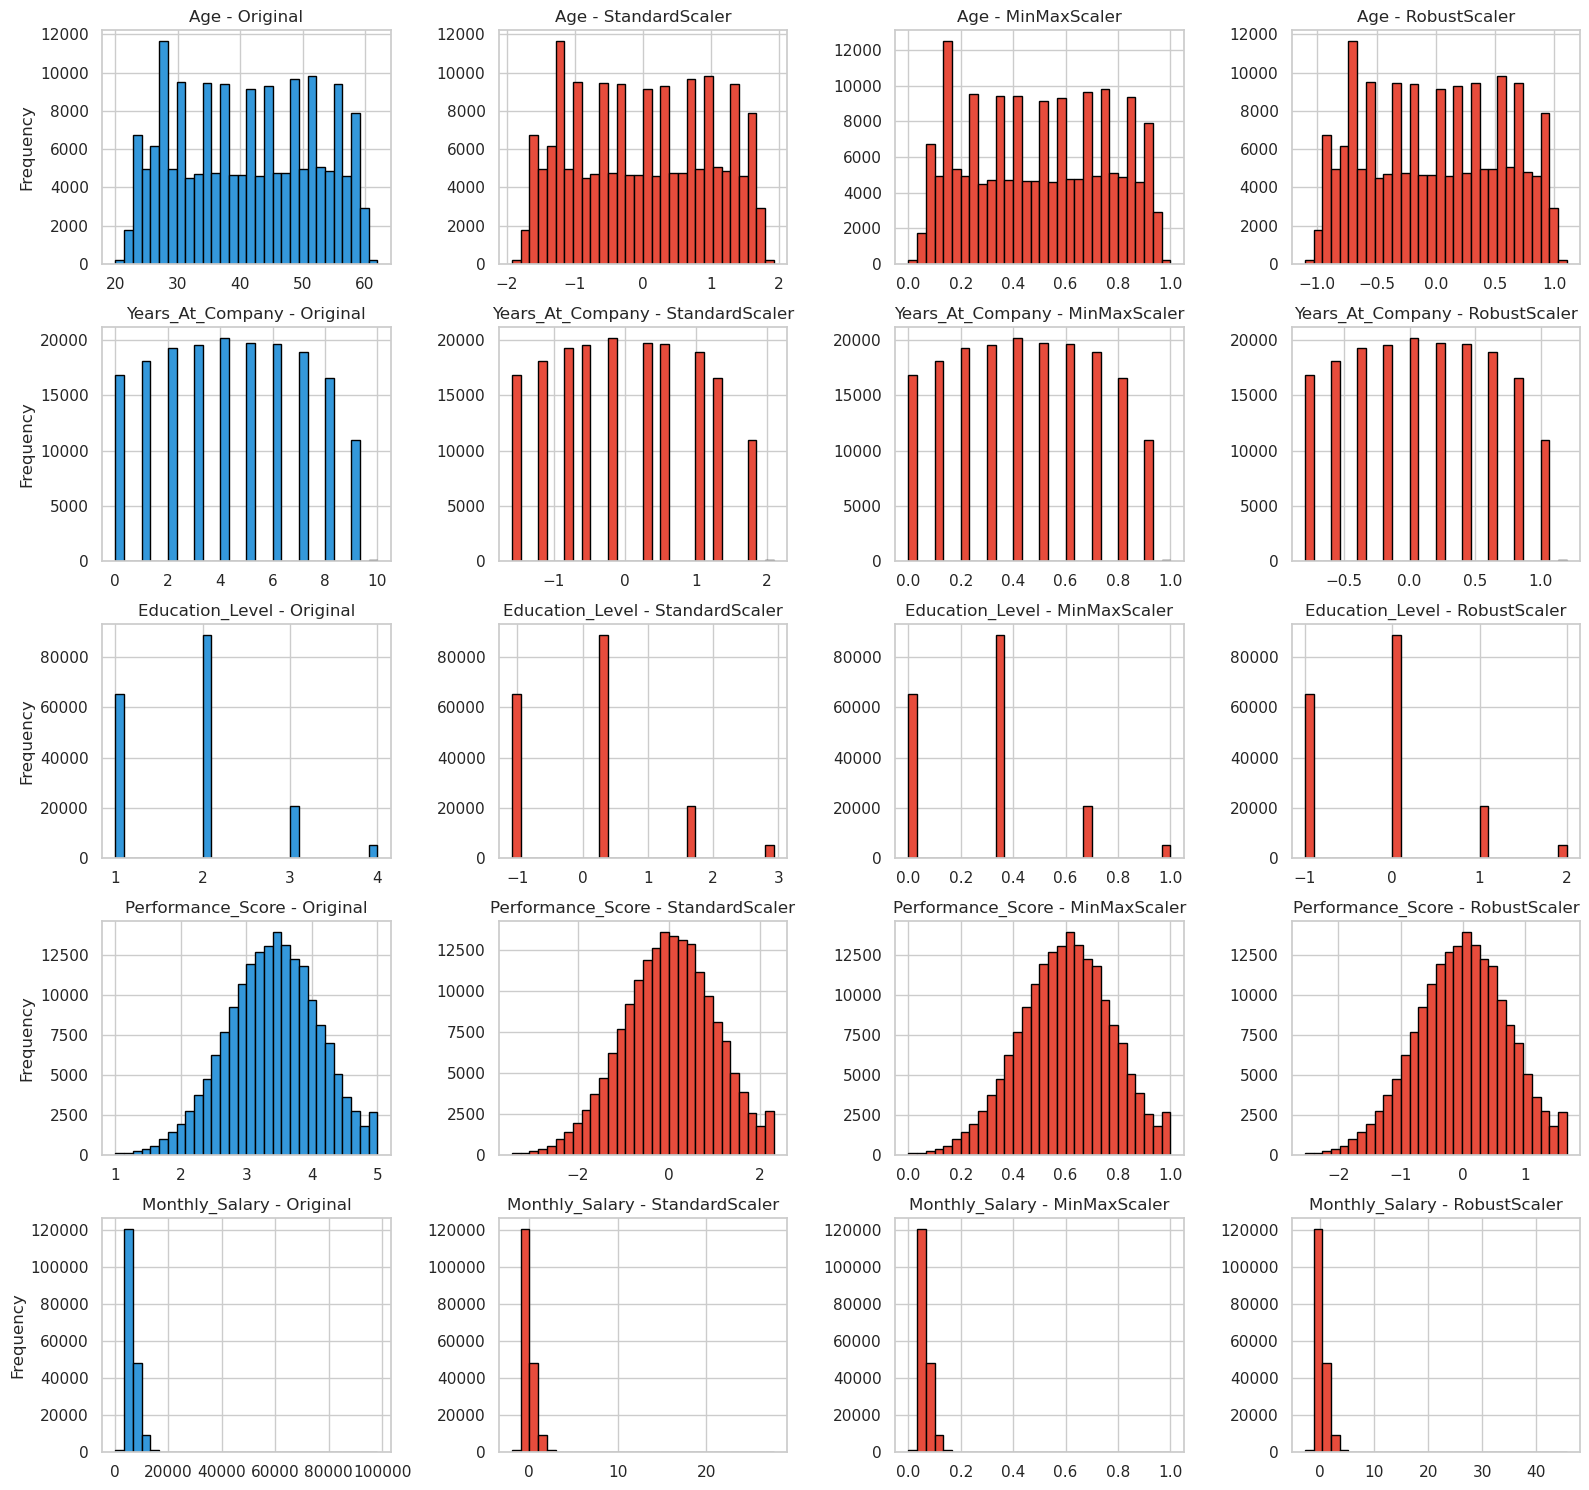


📊 Scaling Method Characteristics:
  - StandardScaler: Mean=0, Std=1 (sensitive to outliers)
  - MinMaxScaler: Range [0,1] (sensitive to outliers)
  - RobustScaler: Uses median & IQR (robust to outliers)

  Recommendation: StandardScaler (most common for ML)

APPLYING STANDARD SCALING

Scaling 45 numeric features...
✓ Scaling completed using StandardScaler

Scaled data statistics (first 5 features):
                Age  Years_At_Company  Education_Level  Performance_Score  Monthly_Salary
count  1.799800e+05      1.799800e+05     1.799800e+05       1.799800e+05    1.799800e+05
mean   7.272029e-17      1.642326e-16     1.465460e-16      -1.238061e-15    2.724839e-16
std    1.000003e+00      1.000003e+00     1.000003e+00       1.000003e+00    1.000003e+00
min   -1.925736e+00     -1.592626e+00    -1.083636e+00      -3.447435e+00   -1.918465e+00
25%   -9.160401e-01     -8.546932e-01    -1.083636e+00      -6.725556e-01   -4.270181e-01
50%    1.865596e-03     -1.167601e-01     2.548088e-01   

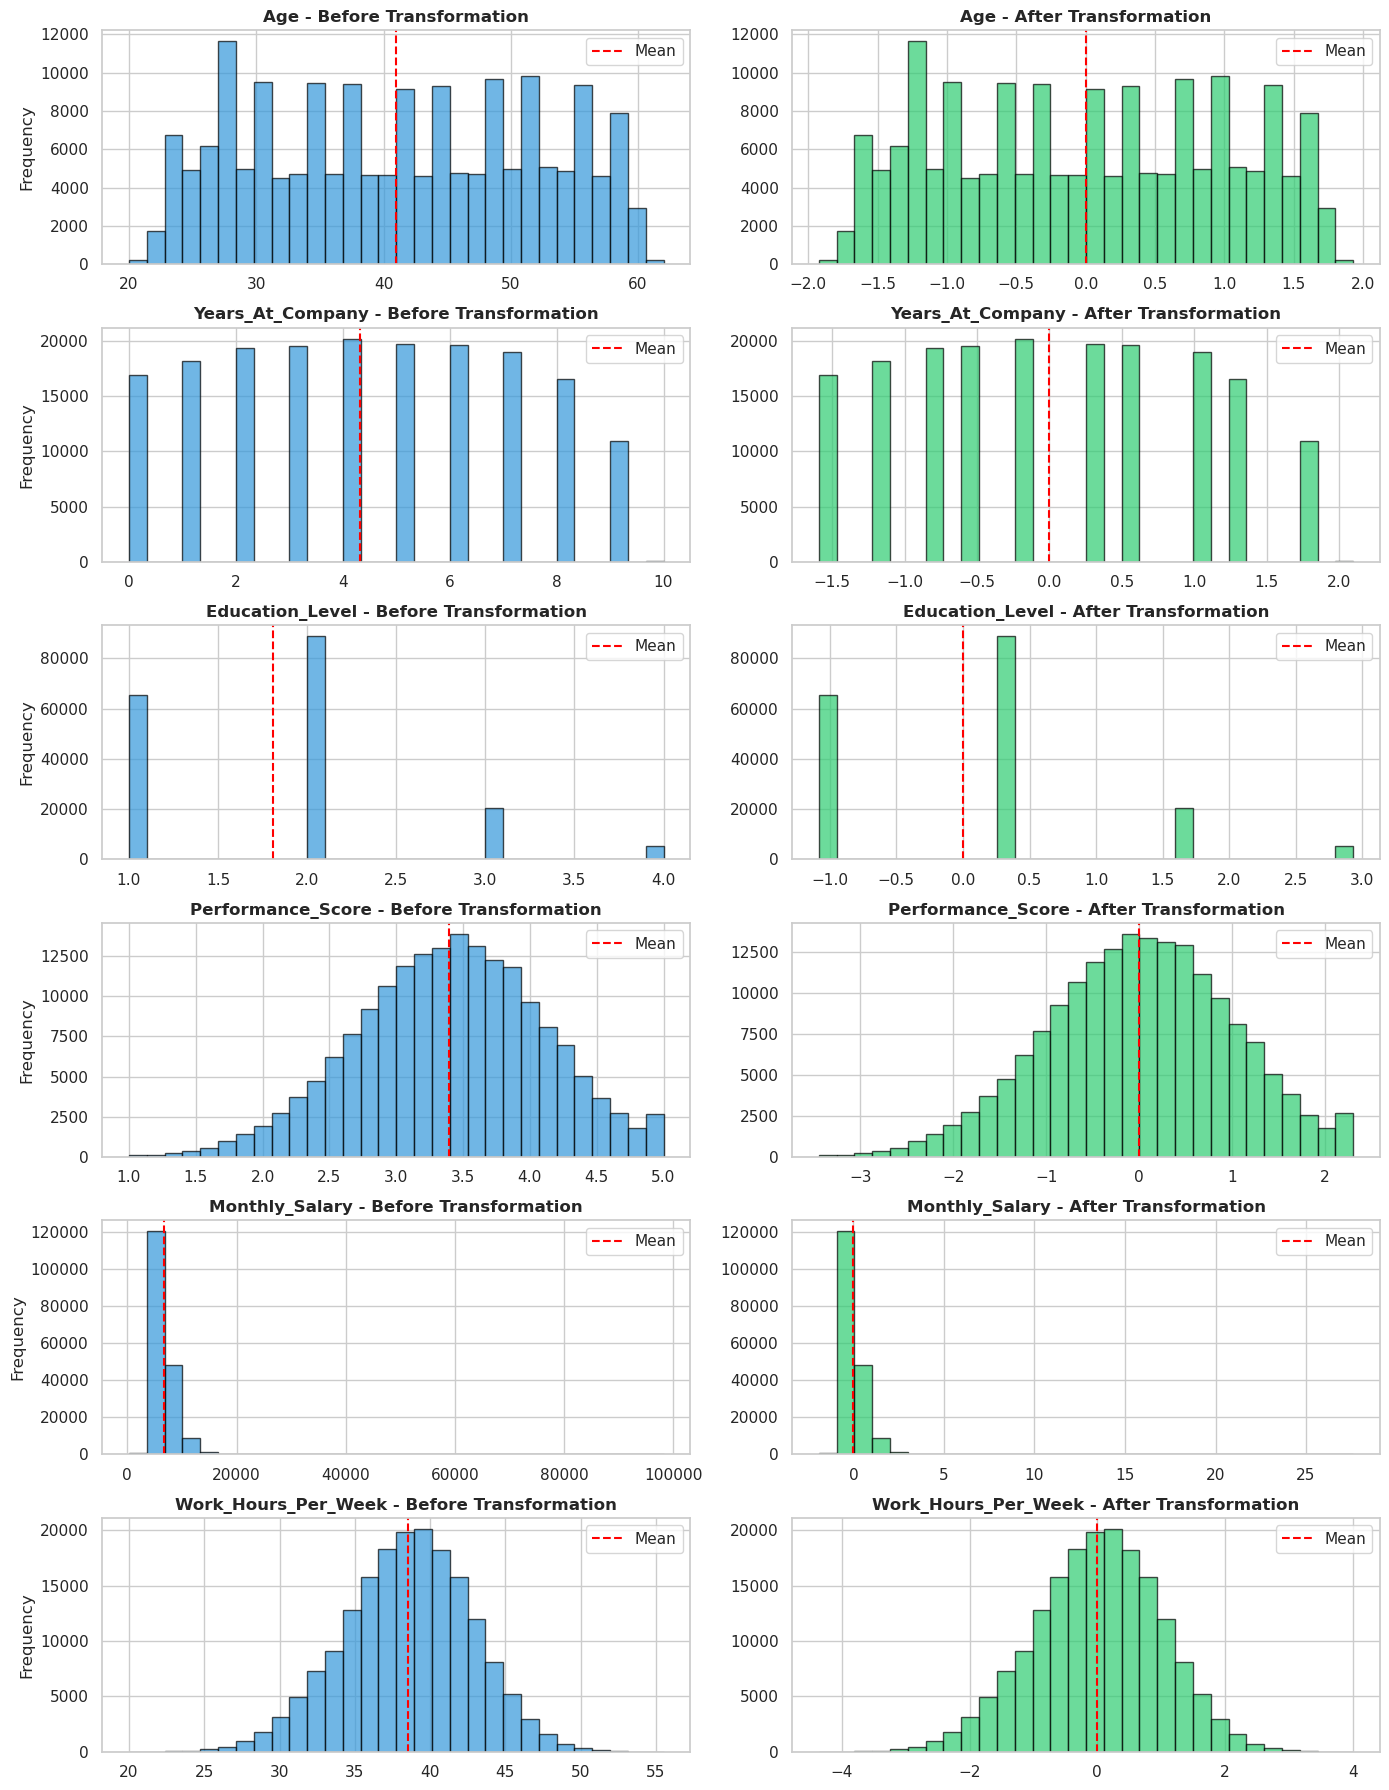

✓ Visualization completed

POST-TRANSFORMATION CORRELATION ANALYSIS

Top 15 correlations with Attrition (after transformation):
Resigned                    1.000000
Burnout_Risk                0.545489
Workload_Intensity          0.523073
Work_Hours_Per_Week         0.476543
Salary_Performance_Gap      0.317037
Projects_Handled            0.228775
Project_Load                0.218243
Tenure_Performance_Ratio    0.168665
Is_Overworked               0.090910
Overtime_Hours              0.077585
Overtime_Ratio              0.054247
Sick_Days                   0.003934
Monthly_Salary              0.002963
Age                        -0.011427
Job_Title_Manager          -0.056788
Name: Resigned, dtype: float64


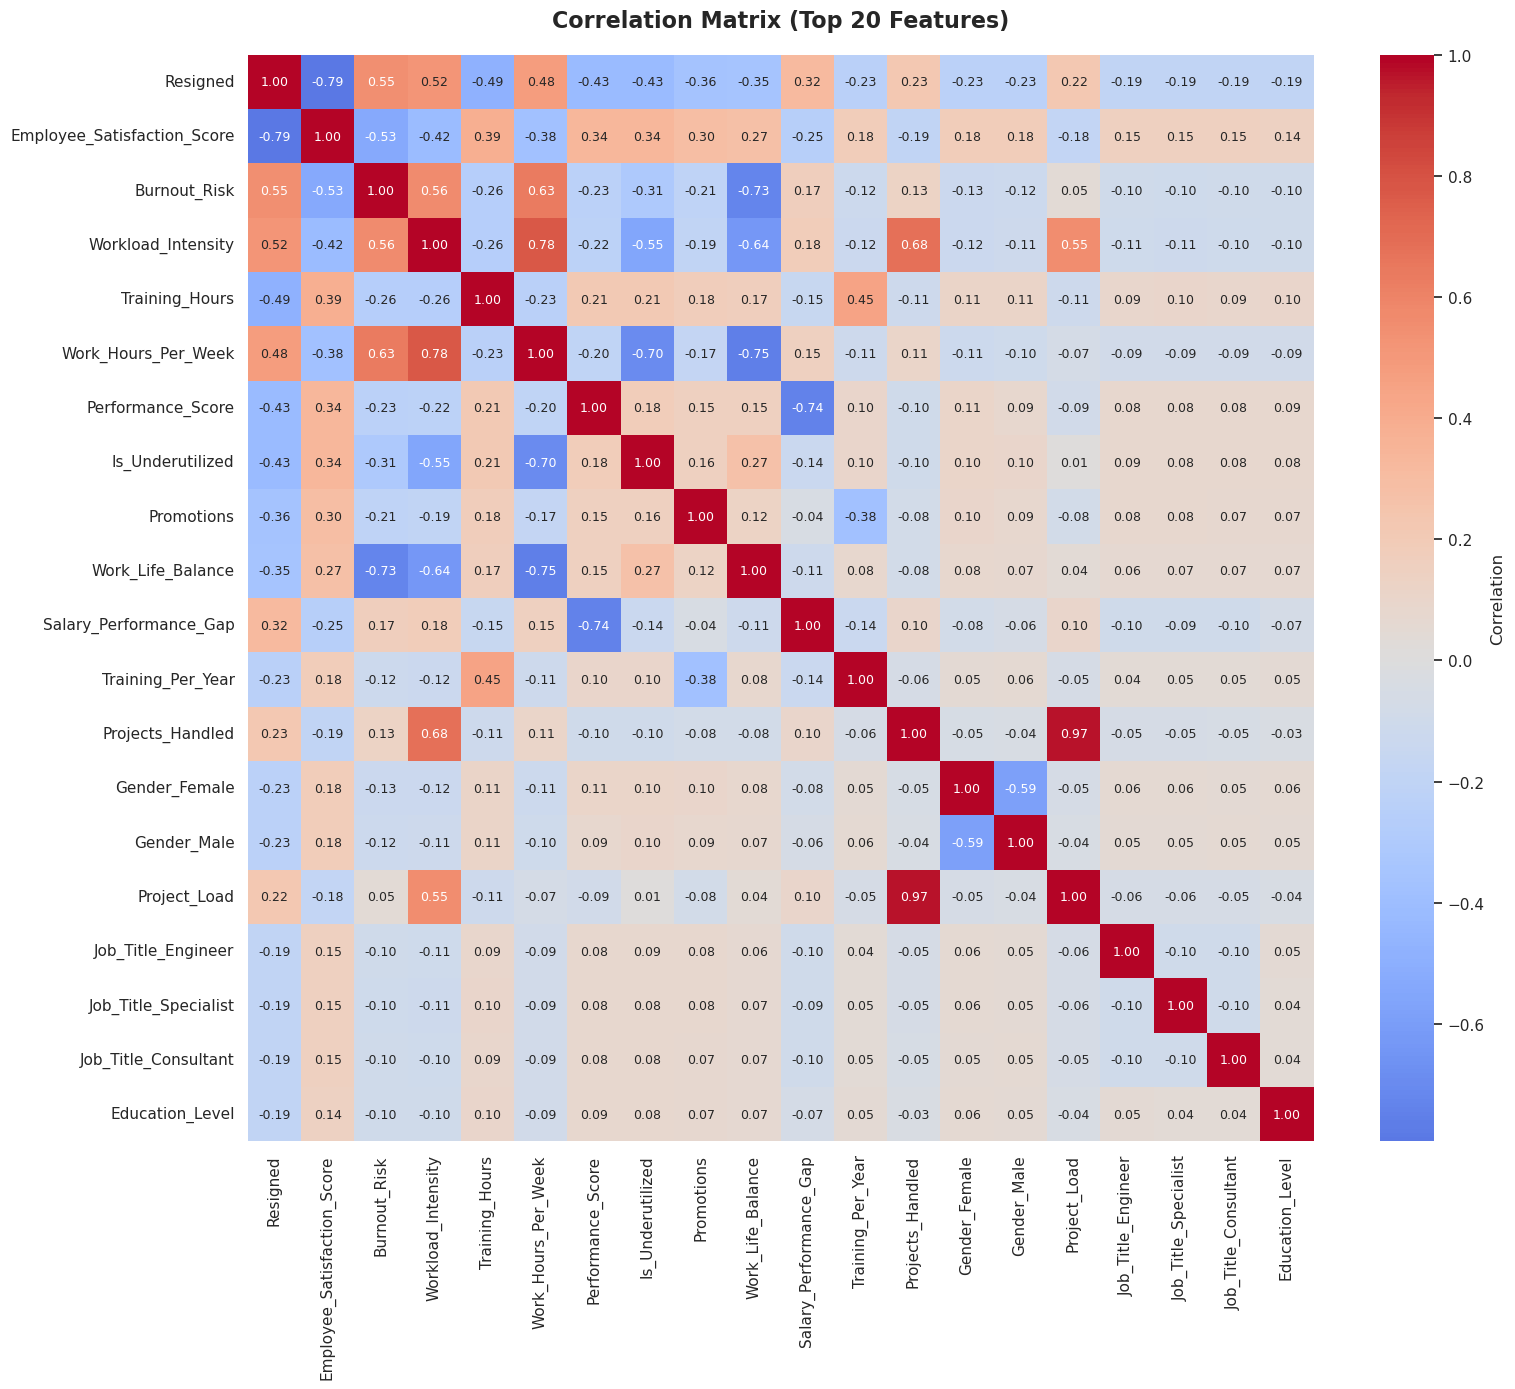

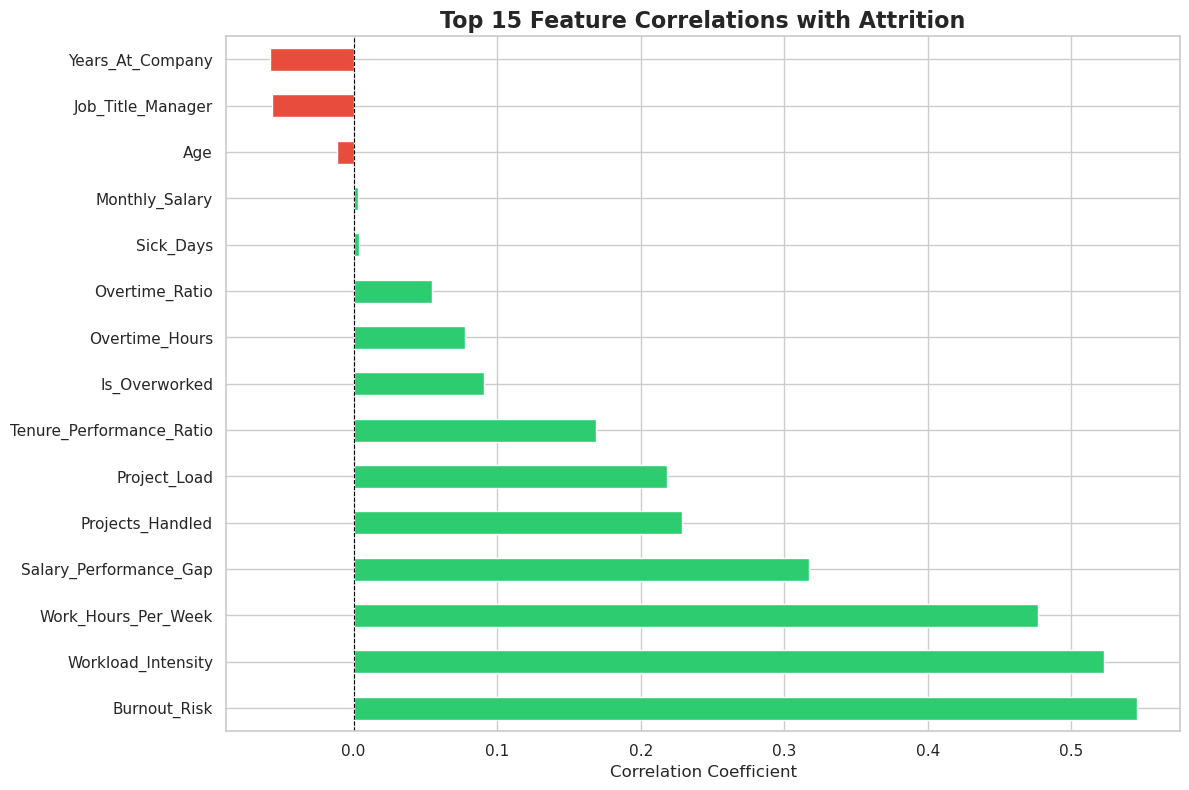


✓ DATA TRANSFORMATION COMPLETED
Transformed dataset shape: (179980, 46)
✓ Scaler saved to: data/scaler.pkl


In [8]:
# Transform data
df_transformed, scaler, transformation_results = data_transformation.transform_data(
    df_balanced.copy(),
    target_col='Resigned',
    scaling_method='standard'
)

# Save transformed data
df_transformed.to_csv('data/transformed_data.csv', index=False)

---
## Phase 6.5: Post-Transformation EDA

**Objective:** Inspect transformed data to ensure quality and readiness.

**Key Activities:**
- Re-run EDA on transformed dataset
- Compare with initial EDA results
- Validate feature distributions
- Confirm correlation patterns


STARTING POST-TRANSFORMATION EDA

DISTRIBUTION COMPARISON: Before vs After Transformation


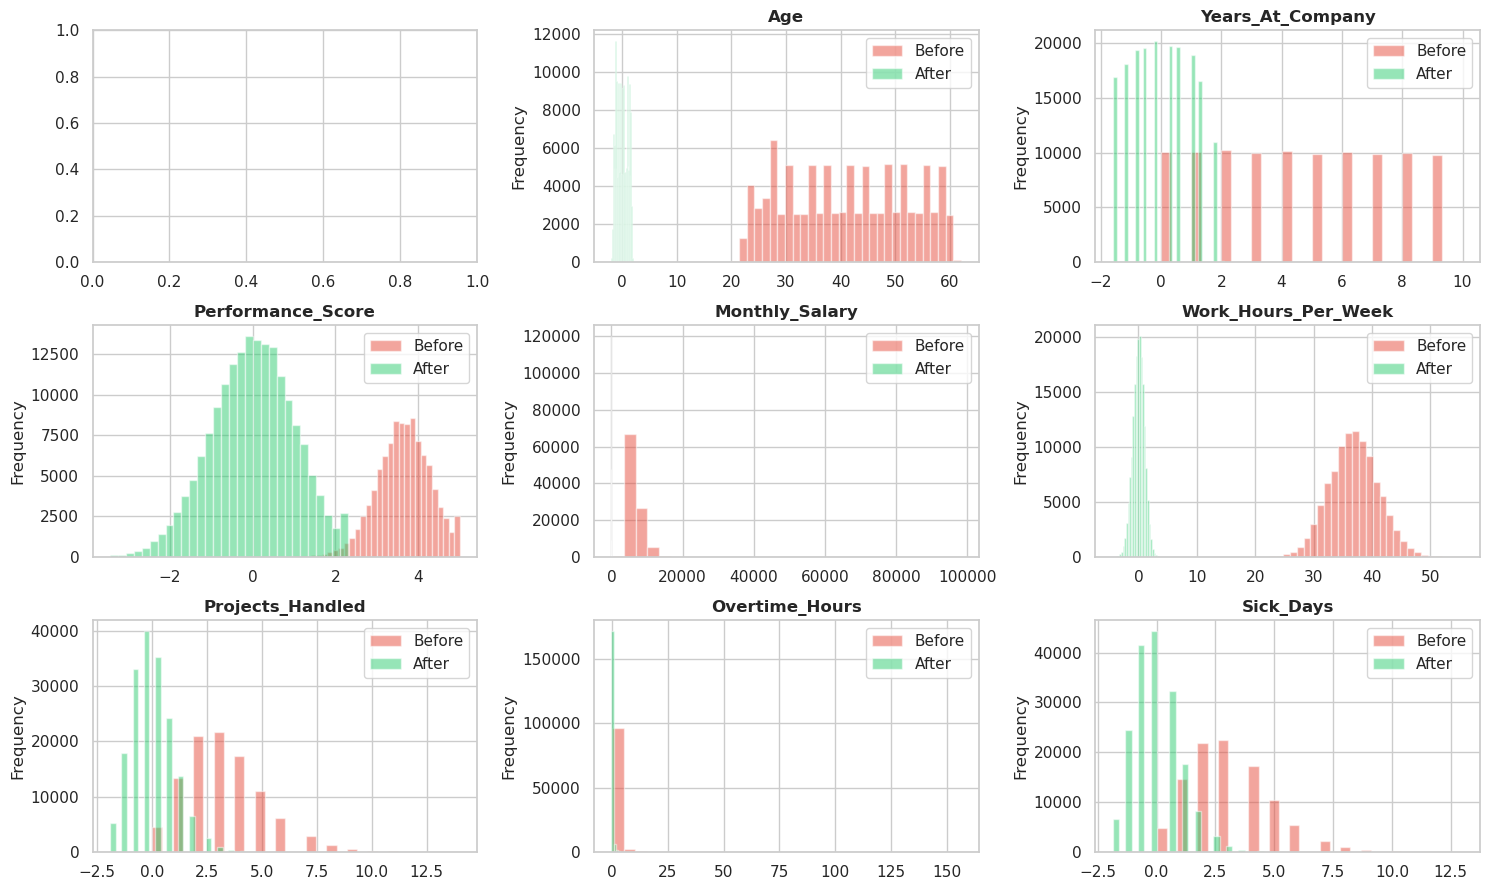

✓ Distribution comparison saved

SKEWNESS REDUCTION ANALYSIS

Top 10 Features with Skewness Reduction:
                    Feature  Skew_Before  Skew_After  Improvement
          Work_Life_Balance    -3.512704   -2.213199     1.299505
Employee_Satisfaction_Score    -0.854569   -0.055471     0.799098
             Overtime_Hours    17.612779   16.881591     0.731187
               Burnout_Risk     1.458159    0.811171     0.646988
     Salary_Performance_Gap     3.802152    3.156820     0.645331
             Monthly_Salary    10.429826   10.024587     0.405238
              Is_Overworked     5.814395    5.416016     0.398379
         Workload_Intensity     0.453528    0.154543     0.298985
             Overtime_Ratio    18.396712   18.183371     0.213341
               Project_Load     0.681136    0.539161     0.141975


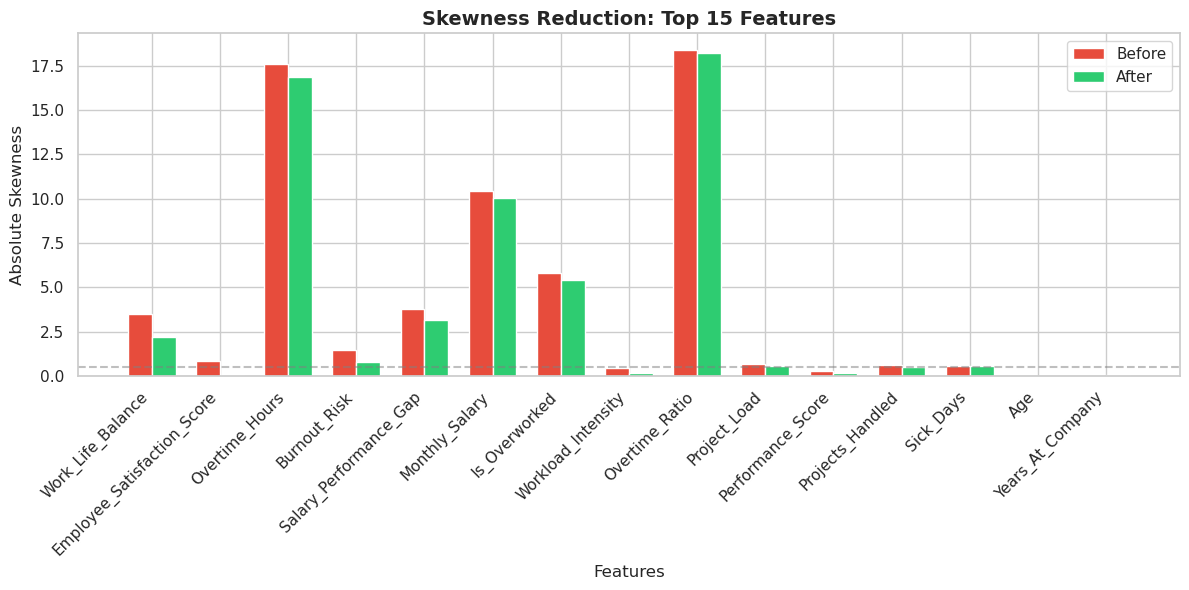


CORRELATION STRENGTH ANALYSIS

Top 15 Features by Correlation with Target:
                    Feature  Corr_Before  Corr_After    Change
Employee_Satisfaction_Score     0.617805    0.794038  0.176233
               Burnout_Risk     0.411653    0.545489  0.133835
         Workload_Intensity     0.341339    0.523073  0.181733
             Training_Hours     0.282227    0.491713  0.209486
        Work_Hours_Per_Week     0.293794    0.476543  0.182749
                 Promotions     0.132203    0.364888  0.232685
          Work_Life_Balance     0.294719    0.352614  0.057895
     Salary_Performance_Gap     0.200052    0.317037  0.116985
          Training_Per_Year     0.110995    0.234242  0.123248
   Tenure_Performance_Ratio     0.103559    0.168665  0.065106
                  Team_Size     0.000200    0.093562  0.093362
              Is_Overworked     0.220809    0.090910 -0.129899
           Years_At_Company     0.000784    0.058617  0.057833
             Overtime_Ratio     0.042931  

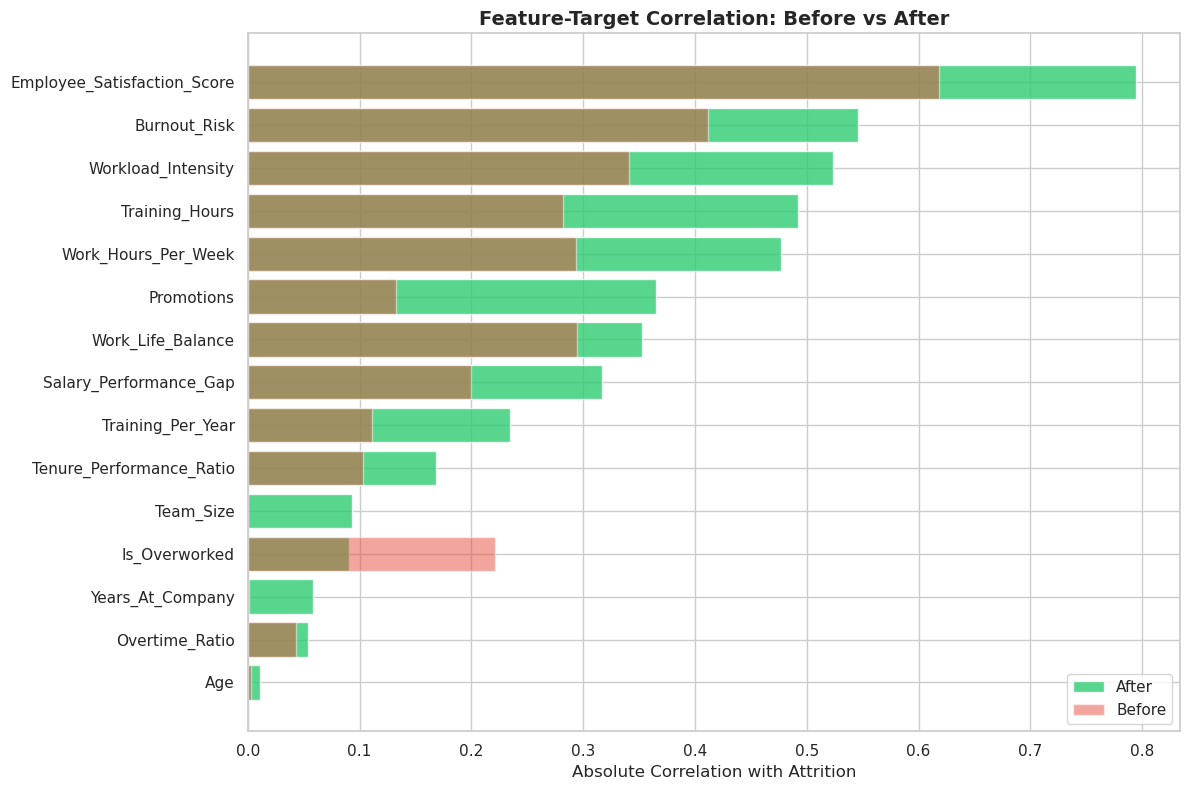


MULTICOLLINEARITY ANALYSIS

High correlation pairs (>0.8):
  Before: 4 pairs
  After: 5 pairs
  Reduction: -1 pairs

Remaining high correlations:
  Overtime_Ratio <-> Overtime_Hours: 0.992
  Project_Load <-> Projects_Handled: 0.967
  Tenure_Performance_Ratio <-> Years_At_Company: 0.879
  Age_Group <-> Age: 0.959
  Tenure_Category <-> Years_At_Company: 0.916

CLASS SEPARABILITY ANALYSIS


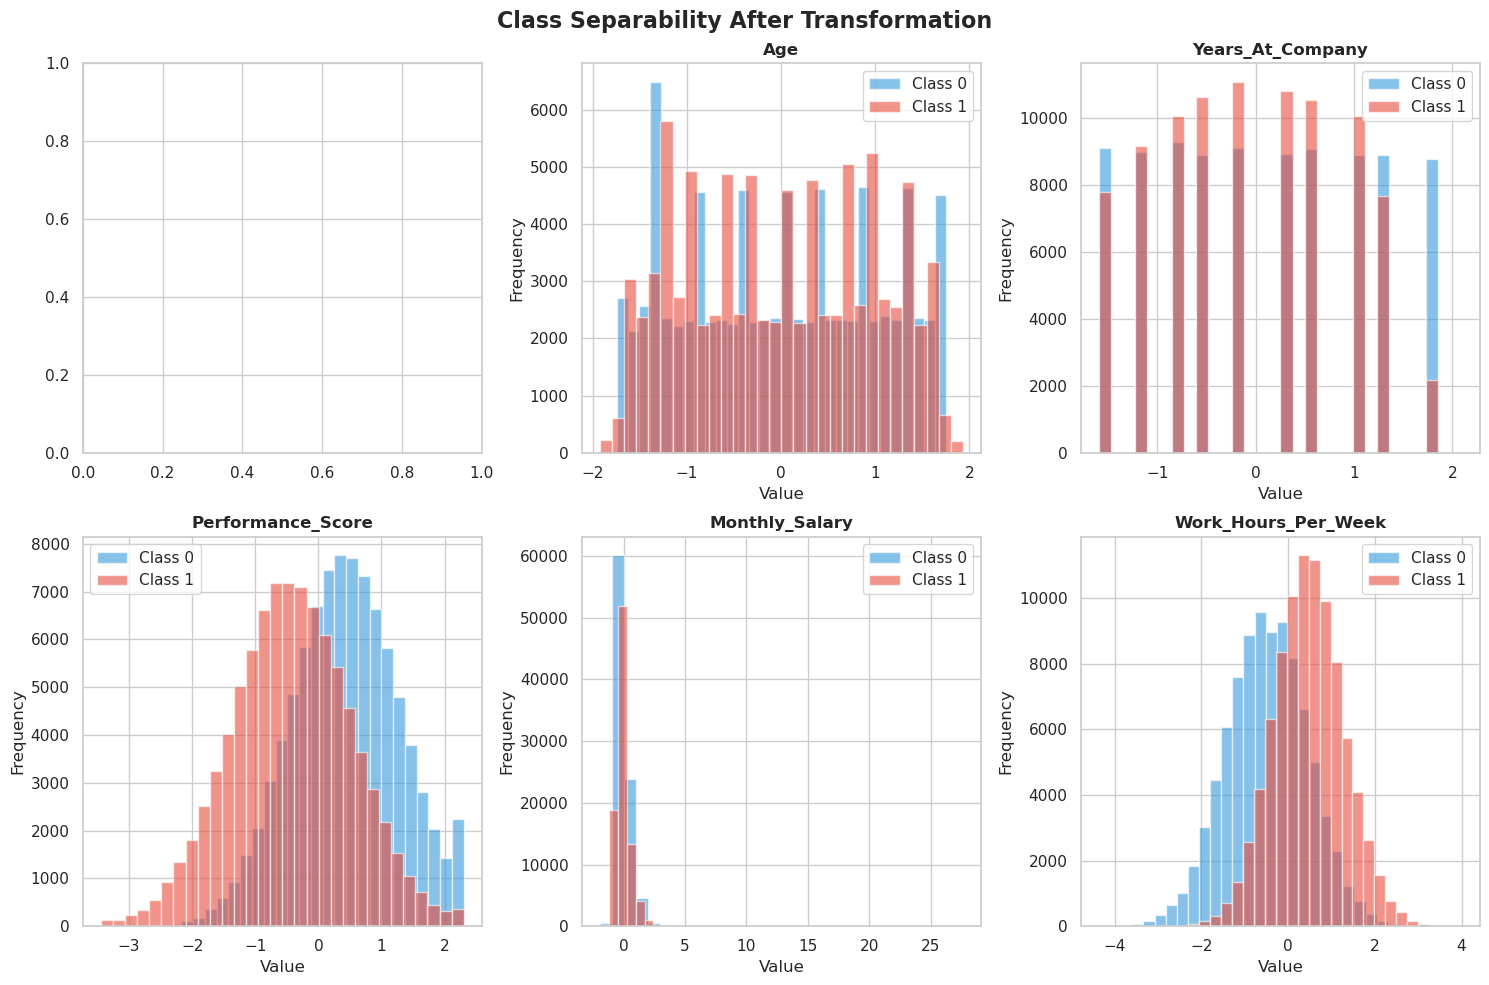

✓ Class separability visualization saved

VARIANCE ANALYSIS

Variance Comparison (Top 10):
                    Feature  Var_Before  Var_After      Ratio
           Projects_Handled    3.375128   1.000006   0.296287
           Years_At_Company    8.233090   1.000006   0.121462
             Overtime_Hours   34.175087   1.000006   0.029261
   Tenure_Performance_Ratio    0.729473   1.000006   1.370860
               Project_Load    0.002588   1.000006 386.346497
          Training_Per_Year   35.572584   1.000006   0.028112
          Work_Life_Balance    0.673547   1.000006   1.484685
Employee_Satisfaction_Score    2.367712   1.000006   0.422351
             Overtime_Ratio    0.001582   1.000006 632.163826
         Workload_Intensity    0.003747   1.000006 266.912773

✓ All features have sufficient variance

POST-TRANSFORMATION SUMMARY REPORT

            Metric      Before       After Status
     Dataset Size 100000 rows 179980 rows      ⚠
    Feature Count          32          46      ✓
 

In [9]:
# Then run
results = post_transformation_eda.run_post_transformation_eda(
    df_before=df_engineered,
    df_after=df_transformed,
    target='Resigned'
)

---
## Phase 7: Data Partition

**Objective:** Split data into training, validation, and test sets for machine learning.

**Key Activities:**
- Stratified split to maintain class distribution
- 65% Training, 15% Validation, 20% Test
- Generate partition quality report
- Save partitioned datasets

**Rationale:**
- Training: Model learning
- Validation: Hyperparameter tuning and model selection
- Test: Final unbiased performance evaluation
- Stratification ensures balanced class distribution across splits

2025-10-31 03:57:18,103 | INFO | ==== DATA PARTITION PIPELINE START ====
2025-10-31 03:57:18,106 | INFO | Starting data partitioning...
2025-10-31 03:57:18,332 | INFO | Data successfully partitioned: Train=116987, Val=26997, Test=35996


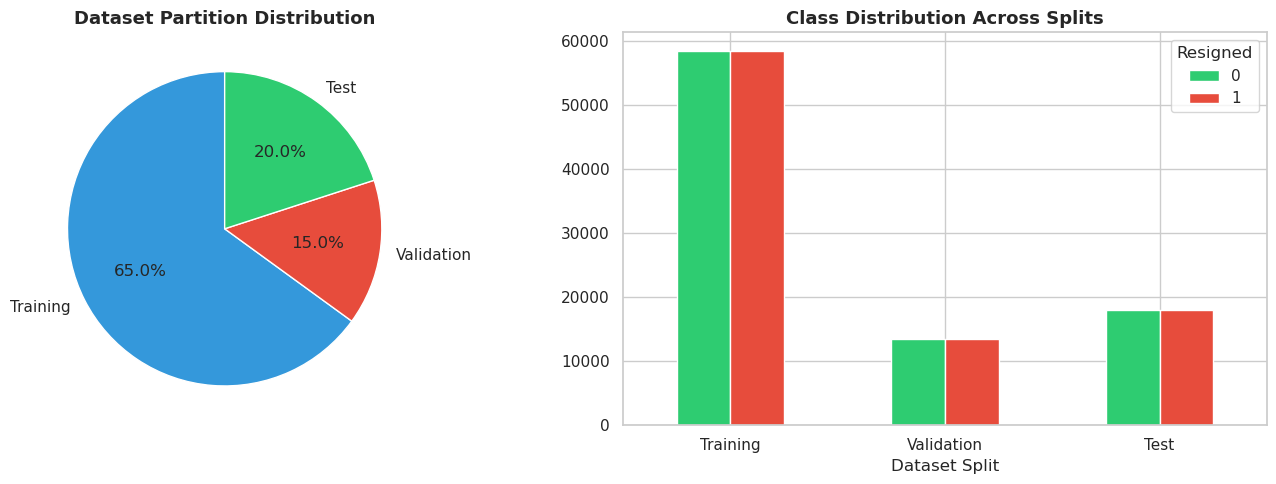

,Split,Samples,Class_0,Class_1,Attrition_Rate_%,Percentage
0,Training,116987,58493,58494,50.000000,65.000000
1,Validation,26997,13499,13498,50.000000,15.000000
2,Test,35996,17998,17998,50.000000,20.000000


2025-10-31 03:57:19,085 | INFO | Stratification check: max class-ratio diff = 0.00%
2025-10-31 03:57:26,955 | INFO | Saved train data → data/train_data.csv ((116987, 46))
2025-10-31 03:57:28,741 | INFO | Saved val data → data/val_data.csv ((26997, 46))
2025-10-31 03:57:31,133 | INFO | Saved test data → data/test_data.csv ((35996, 46))
2025-10-31 03:57:31,137 | INFO | Partition metadata saved as 'partition_metadata.json'.
2025-10-31 03:57:31,138 | INFO | ==== DATA PARTITION PIPELINE COMPLETE ====


In [33]:
# Partition data
partition_results = data_partition.create_data_partition(
    df_transformed.copy(),
    target_col='Resigned',
    test_size=0.20,
    val_size=0.15,
    random_state=42,
    save_data=True,
    output_dir='data'
)

---
## FYP Iteration 1: END